

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from numpy import sqrt

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline



## Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
house = pd.read_csv('./housing.csv')

In [3]:
house.shape

(1460, 81)

In [4]:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
house.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [6]:
house.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [7]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n


- Eliminate any non-residential listings:

    -   A    Agriculture
    -   C    Commercial
    -   FV   Floating Village Residential
    -   I    Industrial
    -   RH   Residential High Density
    -   RL   Residential Low Density
    -   RP   Residential Low Density Park 
    -   RM   Residential Medium Density

In [8]:
house['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [9]:
house.LotArea.describe()

count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

In [10]:
house = house[house.MSZoning != 'C (all)']

In [11]:
house.MSZoning.value_counts()
#more outlier detection required

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

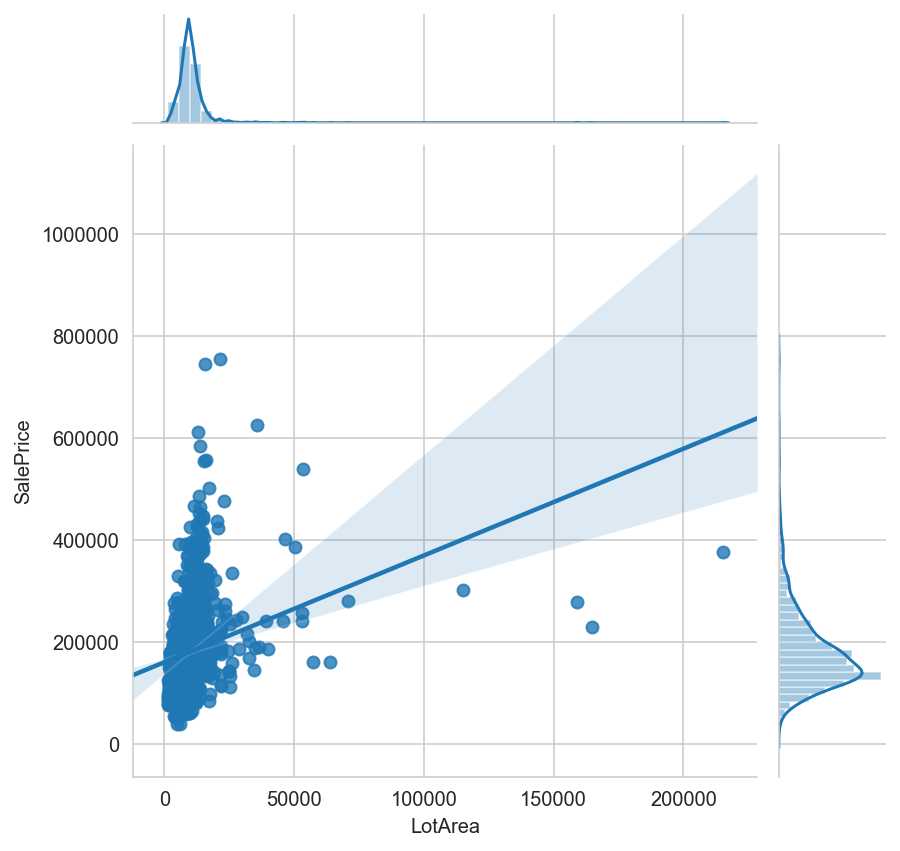

In [12]:
sns.jointplot(x='LotArea', y='SalePrice', data=house, kind='reg')

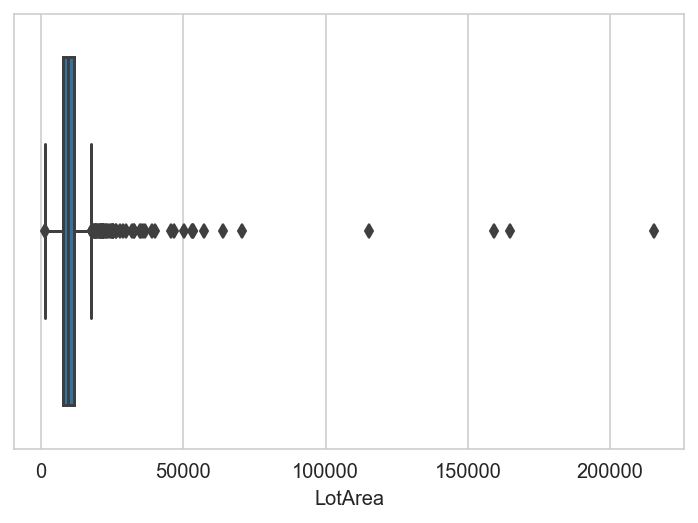

In [13]:
sns.boxplot(x='LotArea', data=house)

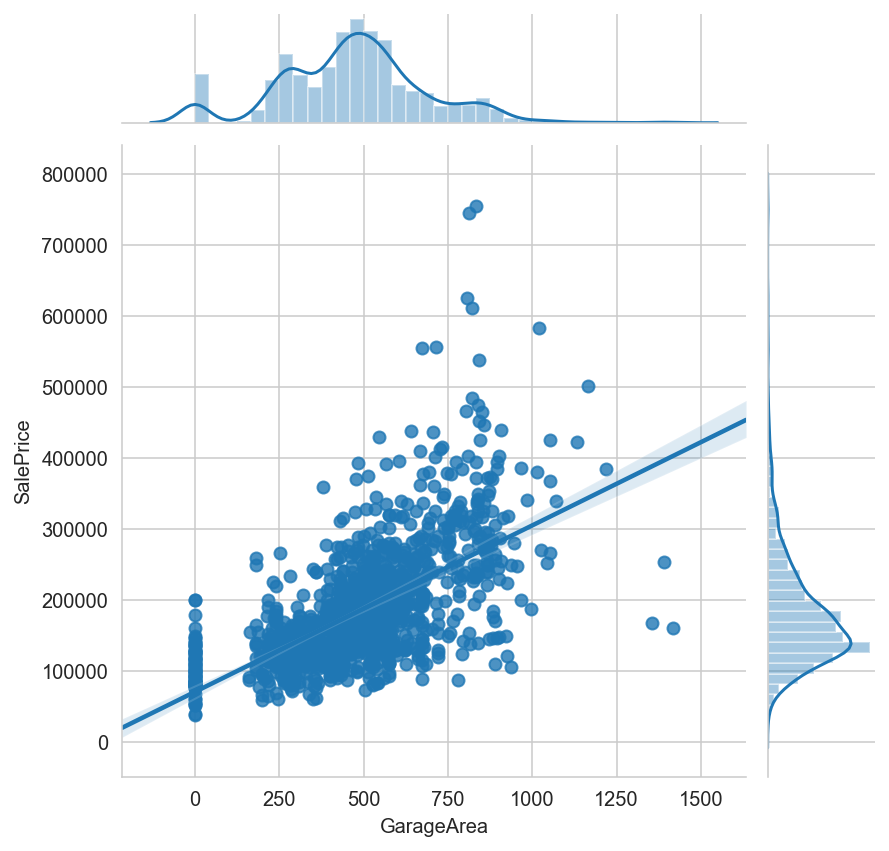

In [14]:
sns.jointplot(x='GarageArea', y='SalePrice', data=house, kind='reg')

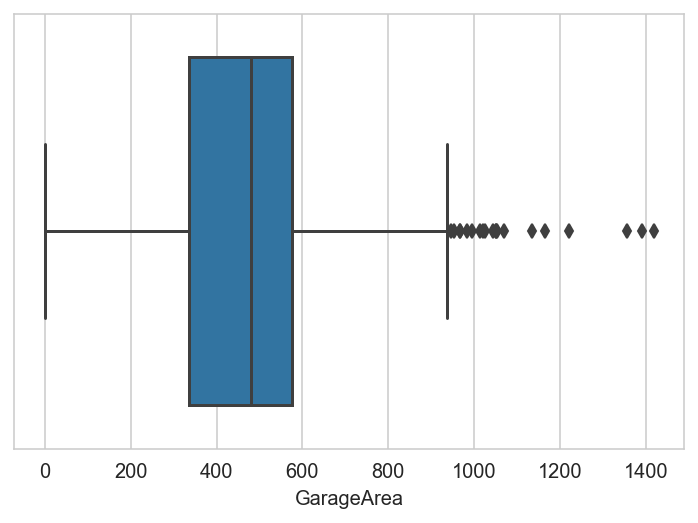

In [15]:
sns.boxplot(x='GarageArea', data=house)

In [16]:
house.MSZoning.value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

In [17]:
house.GarageArea.describe()

count    1450.000000
mean      473.277931
std       212.687621
min         0.000000
25%       336.000000
50%       480.000000
75%       576.000000
max      1418.000000
Name: GarageArea, dtype: float64

In [18]:
house = house[house.MSZoning != 'C (all)']
house = house[house.LotArea < 100000]
house = house[house.GarageArea < 1200]

In [19]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1442 entries, 0 to 1459
Data columns (total 81 columns):
Id               1442 non-null int64
MSSubClass       1442 non-null int64
MSZoning         1442 non-null object
LotFrontage      1187 non-null float64
LotArea          1442 non-null int64
Street           1442 non-null object
Alley            89 non-null object
LotShape         1442 non-null object
LandContour      1442 non-null object
Utilities        1442 non-null object
LotConfig        1442 non-null object
LandSlope        1442 non-null object
Neighborhood     1442 non-null object
Condition1       1442 non-null object
Condition2       1442 non-null object
BldgType         1442 non-null object
HouseStyle       1442 non-null object
OverallQual      1442 non-null int64
OverallCond      1442 non-null int64
YearBuilt        1442 non-null int64
YearRemodAdd     1442 non-null int64
RoofStyle        1442 non-null object
RoofMatl         1442 non-null object
Exterior1st      1442 non-n


    
- There are a lot of object columns which should be either float or integer as they are numbers
- Next step is to convert these values to numbers (if possible)

In [20]:
house.update(house.apply(pd.to_numeric, errors='coerce'))



- Below we can see that many columns have have converted from an object to a float or integer successfully
- The object columns which remain are likely to be strings and therefore categorical data rather than numeric

In [21]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1442 entries, 0 to 1459
Data columns (total 81 columns):
Id               1442 non-null int64
MSSubClass       1442 non-null int64
MSZoning         1442 non-null object
LotFrontage      1187 non-null float64
LotArea          1442 non-null int64
Street           1442 non-null object
Alley            89 non-null object
LotShape         1442 non-null object
LandContour      1442 non-null object
Utilities        1442 non-null object
LotConfig        1442 non-null object
LandSlope        1442 non-null object
Neighborhood     1442 non-null object
Condition1       1442 non-null object
Condition2       1442 non-null object
BldgType         1442 non-null object
HouseStyle       1442 non-null object
OverallQual      1442 non-null int64
OverallCond      1442 non-null int64
YearBuilt        1442 non-null int64
YearRemodAdd     1442 non-null int64
RoofStyle        1442 non-null object
RoofMatl         1442 non-null object
Exterior1st      1442 non-n



**Null Values**
- Drop columns with over 50% null values:


In [22]:
house = house.drop(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis=1)



**Numerical Null Values**
- Numerical columns with missing data:
    - LotFrontage - Linear feet of street connected to property - 255 null
    - MasVnrArea : Masonry veneer area in square feet  - 8 null
    - GarageYrBlt - Year garage was built - 79 null
- Look into the overview of statistics for these columns:

In [24]:
house[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].describe()

,LotFrontage,MasVnrArea,GarageYrBlt
count,1187.000000,1434.000000,1363.000000
mean,69.720303,102.971409,1978.606016
std,23.129577,179.583837,24.613360
min,21.000000,0.000000,1906.000000
25%,59.000000,0.000000,1961.000000
50%,70.000000,0.000000,1980.000000
75%,80.000000,165.750000,2002.000000
max,313.000000,1600.000000,2010.000000




- The distribution looks relatively normal for these columns. 
- Therefore, rather than removing the rows with null values (which could be useful data for the model), it will be filled with the median value
- Filling with the median value will fill the empty rows whilst not impacting the distribution of the data
- Using the describe function below confirms that the rows have been filled (count 1442) and mean, median (50%) have not changed
- and the isnull().isany() functions show that there are no null values for the numerical columns of data

In [25]:
house = house.fillna(house[['LotFrontage', 'MasVnrArea','GarageYrBlt']].median())

In [26]:
house[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].describe()

,LotFrontage,MasVnrArea,GarageYrBlt
count,1442.000000,1442.000000,1442.000000
mean,69.769764,102.400139,1978.682386
std,20.983778,179.248009,23.931265
min,21.000000,0.000000,1906.000000
25%,60.000000,0.000000,1962.000000
50%,70.000000,0.000000,1980.000000
75%,79.000000,164.000000,2001.000000
max,313.000000,1600.000000,2010.000000


In [27]:
house.select_dtypes(include=('float64', 'int64')).isnull().sum().any()

False



**Categorical Null Values**
- To fill the rest of the columns (which are categorical), we will fill with the mode or most common value in the column
- This can be done with a lambda function which fills every null value with the column's most frequent value 
- The describe function before and after shows that the null values have been entered (count) and the mode is the same (top)
- To validate all null values have been removed from the dataset isnull().any().value_counts() shows that 75 columns returned False, which is also the count of all the columns in the dataset of 75

In [28]:
house.select_dtypes(include=('object')).isnull().any().value_counts()

False    27
True     11
dtype: int64

In [29]:
house[['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
       'BsmtFinType2', 'GarageType', 'Electrical', 'GarageFinish','GarageQual', 'GarageCond']].describe()


,MasVnrType,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,GarageType,Electrical,GarageFinish,GarageQual,GarageCond
count,1434,1405,1405,1404,1405,1404,1363,1441,1363,1363,1363
unique,4,4,4,4,6,6,6,5,3,5,5
top,None,TA,TA,No,Unf,Unf,Attchd,SBrkr,Unf,TA,TA
freq,852,637,1295,946,423,1240,863,1320,599,1295,1311


In [30]:
categories_null = [['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
       'BsmtFinType2', 'GarageType', 'Electrical', 'GarageFinish','GarageQual', 'GarageCond']]

In [32]:
house = house.fillna('unknown')

In [33]:
house.isnull().sum().any()

False

In [34]:
house[['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
       'BsmtFinType2', 'GarageType', 'Electrical', 'GarageFinish','GarageQual', 'GarageCond']].describe()

,MasVnrType,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,GarageType,Electrical,GarageFinish,GarageQual,GarageCond
count,1442,1442,1442,1442,1442,1442,1442,1442,1442,1442,1442
unique,5,5,5,5,7,7,7,6,4,6,6
top,None,TA,TA,No,Unf,Unf,Attchd,SBrkr,Unf,TA,TA
freq,852,637,1295,946,423,1240,863,1320,599,1295,1311


In [35]:
house.MasVnrType.value_counts()

None       852
BrkFace    443
Stone      125
BrkCmn      14
unknown      8
Name: MasVnrType, dtype: int64

In [36]:
house.isnull().any().value_counts()

False    76
dtype: int64

In [37]:
len(house.columns)

76



**Rename Columns with first character as digit**

In [38]:
house.columns.sort_values().values

array(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BldgType',
       'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual',
       'Exterior1st', 'Exterior2nd', 'Fireplaces', 'Foundation',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt',
       'GrLivArea', 'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle',
       'Id', 'KitchenAbvGr', 'KitchenQual', 'LandContour', 'LandSlope',
       'LotArea', 'LotConfig', 'LotFrontage', 'LotShape', 'LowQualFinSF',
       'MSSubClass', 'MSZoning', 'MasVnrArea', 'MasVnrType', 'MiscVal',
       'MoSold', 'Neighborhood', 'OpenPorchSF', 'OverallCond',
       'OverallQual', 'PavedDrive', 'PoolArea', 'RoofMatl', 'RoofStyle',
       'SaleCondition', 'S

In [39]:
cols={'1stFlrSF': 'FirstFlrSF', '2ndFlrSF': 'SecondFlrSF', '3SsnPorch': 'ThirdsnPorch'}
house.rename(columns=cols, inplace=True)

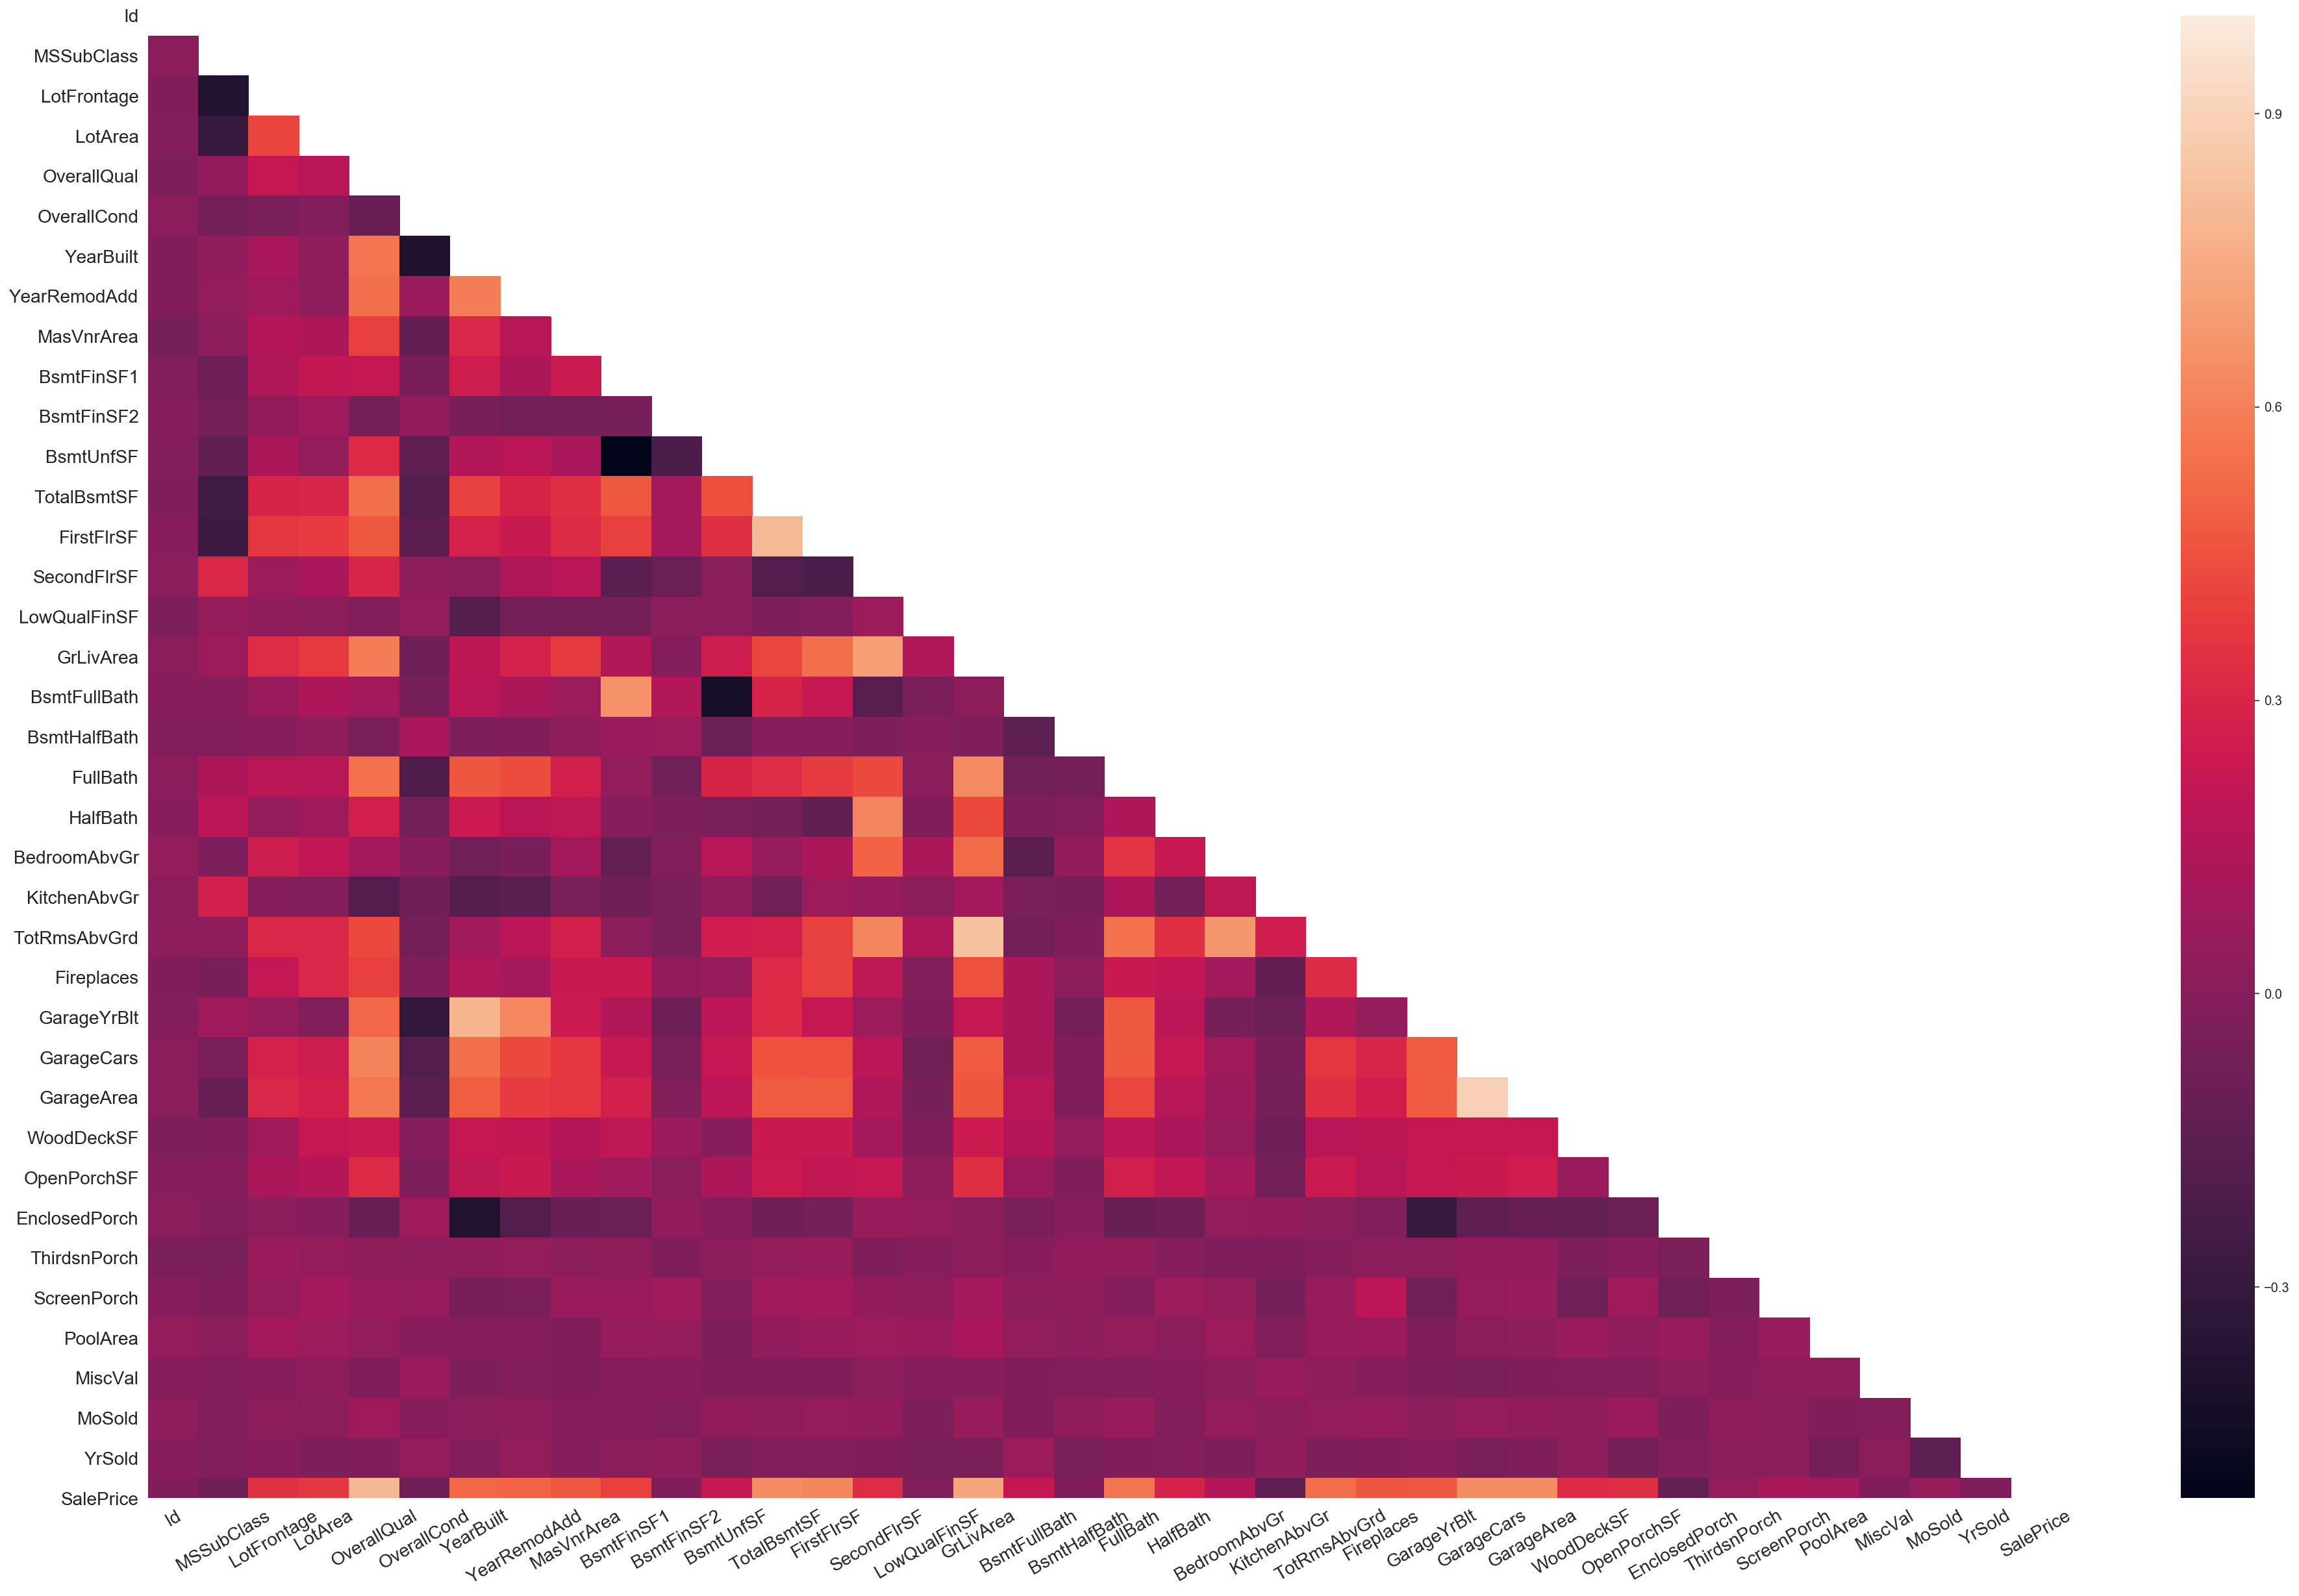

In [40]:
def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(33,21))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

correlation_heat_map(house)



**Remove columns have a collinear realtionship**
- These have been confirmed by looking at colinear relationships above and by looking at description of columns on kaggle website and /  

- BsmtFinType1', 'BsmtFinType2' - remove BsmtFinType2
- 'BsmtFullBath', 'BsmtHalfBath' - remove BsmtHalfBath
- 'Condition1', 'Condition2' - remove Condition2
- Exterior1st', 'Exterior2nd' - remove Exterior2nd
- 'GarageArea', 'GarageCars' - remove GarageCars
- 'FullBath', 'HalfBath' - remove HalfBath
- 'BsmtFinSF1', 'BsmtFinSF2','TotalBsmtSF' - remove BsmtFinSF2 and BsmtFinSF1
- 'BsmtUnfSF', 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF' - keep only TotalBsmtSF
- 'OpenPorchSF', 'ScreenPorch', 'ThirdsnPorch', 'WoodDeckSF', 'EnclosedPorch' - remove all
- 'ExterCond', 'ExterQual' - remove ExterCond
- 'BsmtCond', BsmtQual - although these sound the same BsmtCond describes the general condition of the basement and BsmtQual Evaluates the height of the basement - these may be slightly linked. e.g. Basements of a better quality may be larger. BsmtQual carries less information overall and is removed

In [41]:
len(house.columns.sort_values().values)

76

In [42]:
house.columns.sort_values().values

array(['BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExposure',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2',
       'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF',
       'CentralAir', 'Condition1', 'Condition2', 'Electrical',
       'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st',
       'Exterior2nd', 'Fireplaces', 'FirstFlrSF', 'Foundation',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt',
       'GrLivArea', 'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle',
       'Id', 'KitchenAbvGr', 'KitchenQual', 'LandContour', 'LandSlope',
       'LotArea', 'LotConfig', 'LotFrontage', 'LotShape', 'LowQualFinSF',
       'MSSubClass', 'MSZoning', 'MasVnrArea', 'MasVnrType', 'MiscVal',
       'MoSold', 'Neighborhood', 'OpenPorchSF', 'OverallCond',
       'OverallQual', 'PavedDrive', 'PoolArea', 'RoofMatl', 'RoofStyle',
       'SaleCondition', 'SalePrice', 'SaleType', 

In [43]:
house = house.drop(['BsmtFinType2', 'BsmtHalfBath', 'Condition2', 'Exterior2nd', 'GarageCars', 'HalfBath', 
                    'BsmtFinSF2', 'BsmtUnfSF', 'FirstFlrSF', 'SecondFlrSF', 'OpenPorchSF', 'ScreenPorch', 
                    'ThirdsnPorch', 'WoodDeckSF', 'EnclosedPorch','BsmtFinSF1', 'ExterCond', 'BsmtQual'], axis=1)

In [44]:
len(house.columns)

58



**Feature Engineering to merge columns**
- 'BsmtFullBath' and 'FullBath' are described as Basement full bathrooms and Full bathrooms above grade respectively
- Grade means above basement level.
- Thereofre, I will combine these columns to make one 'TotalFullBath'

In [45]:
house['TotalFullBath'] = house['BsmtFullBath'] + house['FullBath']
house = house.drop(['BsmtFullBath','FullBath'], axis=1)

## EDA of the data

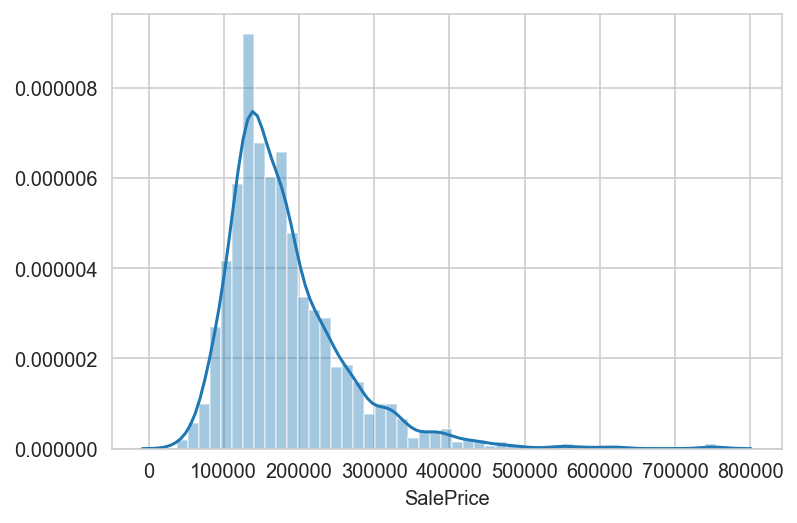

In [46]:
sns.distplot(house.SalePrice)
plt.show()



- The Target 'Sale Price' is positively skewed
- However the distribution overall looks relatively normal which is useful for building models to predict the target
- The mean house price is \$181,172
- The median house price is \$163,250

In [47]:
house.SalePrice.describe()

count      1442.000000
mean     181172.276699
std       78910.844528
min       37900.000000
25%      130000.000000
50%      163250.000000
75%      213875.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [48]:
len(house.Neighborhood.value_counts())

25

In [49]:
house.Neighborhood.value_counts()

NAmes      225
CollgCr    150
OldTown    112
Edwards     99
Somerst     86
Gilbert     79
NridgHt     75
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     48
NoRidge     41
Timber      36
IDOTRR      28
ClearCr     26
SWISU       25
StoneBr     25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

In [50]:
neighborhood = house.Neighborhood.unique()
neighborhood.sort()  
neighborhood

array(['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr',
       'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel',
       'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown',
       'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber',
       'Veenker'], dtype=object)

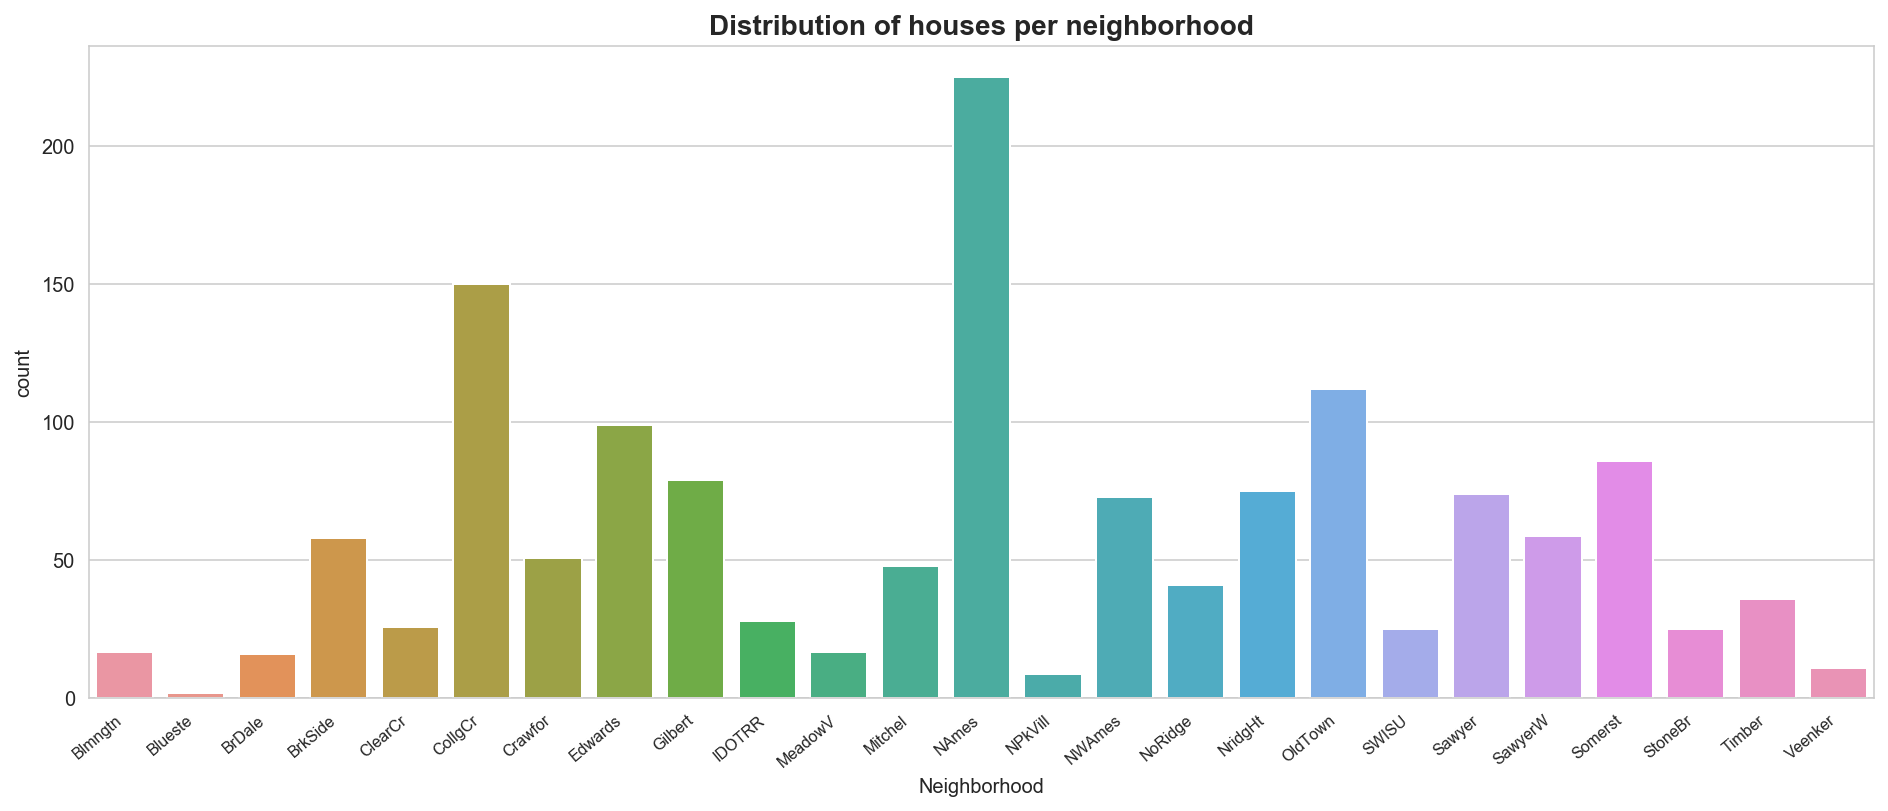

In [51]:
plt.figure(figsize=(16,6))
ax = sns.countplot(x='Neighborhood', data=house, order=neighborhood)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=8)
plt.title('Distribution of houses per neighborhood', fontsize=14, fontweight='bold')
plt.show()

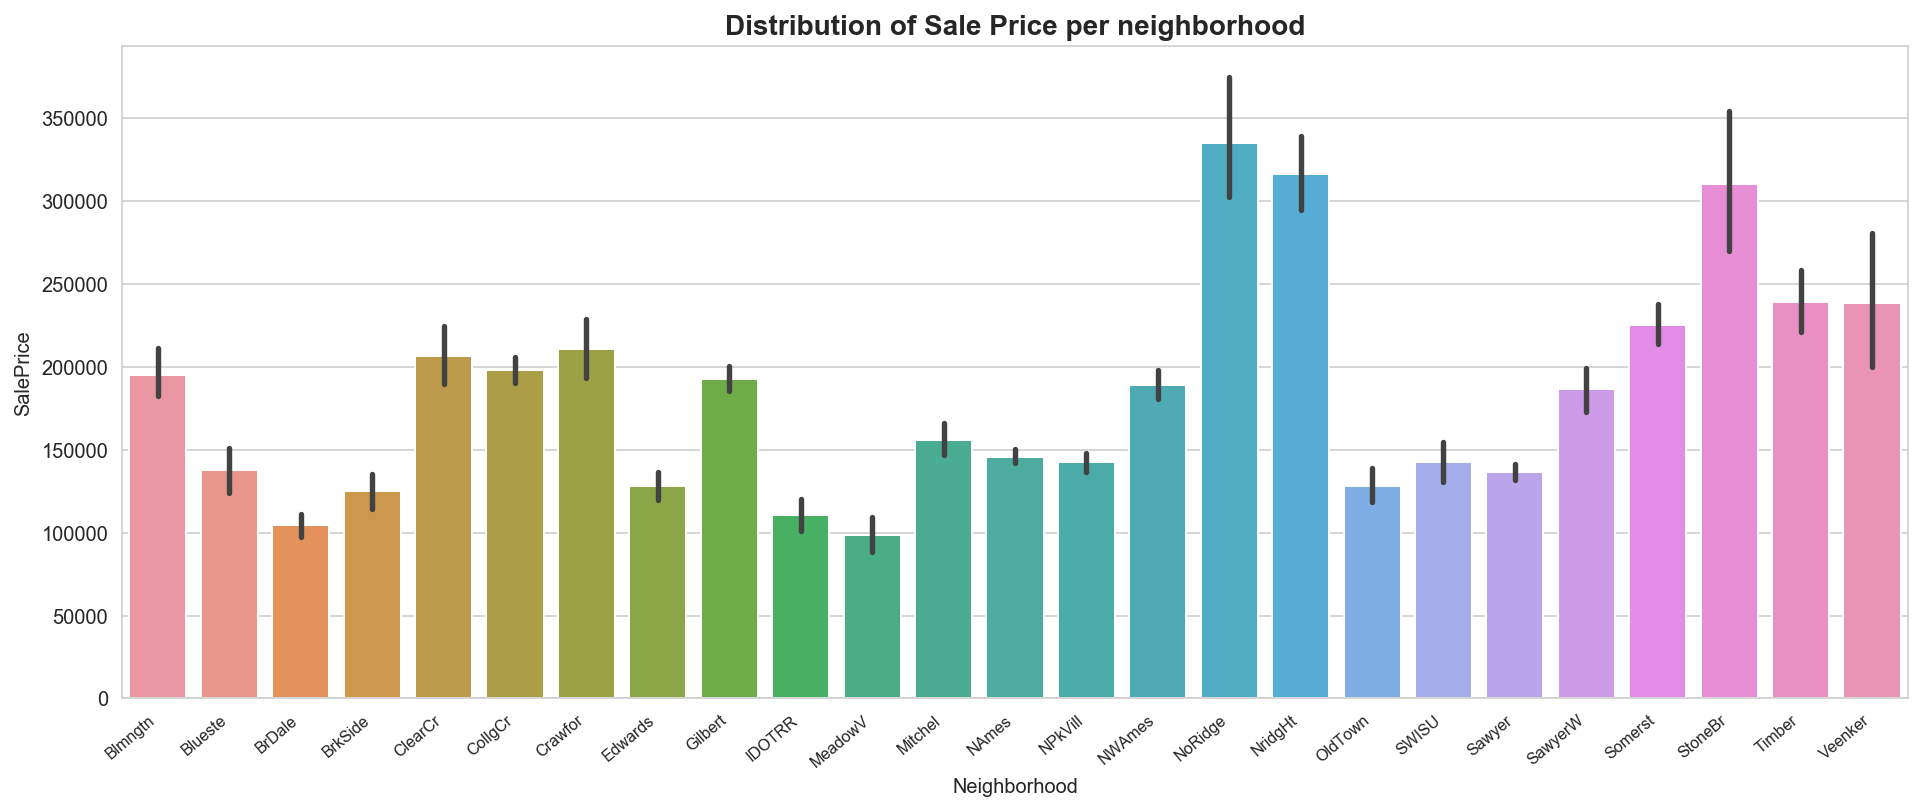

In [52]:
plt.figure(figsize=(16,6))
ax = sns.barplot(x='Neighborhood', y= 'SalePrice', data=house, order=neighborhood)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=8)
plt.title('Distribution of Sale Price per neighborhood', fontsize=14, fontweight='bold')
plt.show()

In [53]:
house.Neighborhood.value_counts()

NAmes      225
CollgCr    150
OldTown    112
Edwards     99
Somerst     86
Gilbert     79
NridgHt     75
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     48
NoRidge     41
Timber      36
IDOTRR      28
ClearCr     26
SWISU       25
StoneBr     25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64



- There 25 different Neighborhoods in this data set
- Value counts shows that 3 Neighborhood have a lot more entries in our data set - visualisation is a lot more friendly on the eye than the statistics...
- The first graph shows the count of each Neighborhood in our sample. The most counts are from NAmes, CollgrCr and OldTown
- The second graph shows the distribution of the Sale Price from Neighborhood to Neighborhood.  This seems to be inversely related to the count of houses in the neighborhood
- The prestigious and expensive areas have less house sales in our sample. This may be because there a fewer but larger houses in these areas. The affluent neighborhoods include NoRidge, NridgHt and StoneBr.

In [54]:
house.SalePrice.median()

163250.0

In [55]:
house.SalePrice.mean()

181172.2766990291

## Preparing the data for the model

**Numerical data** are necessary for training and testing data. However some data with different ranges need to be **scaled** so that they are comparable with each other and are reliable predictors of the target. 
- Of the list of numerical columns below, each column is looked at individually and it is determined if it should be scaled or not. e.g. LotFrontage is the area in square metres and will vary from 0 to 4000 and should be scaled, however Year Built should not be scaled as it would distort year value in the column

In [56]:
house.select_dtypes(include=('float64', 'int64')).columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF',
       'LowQualFinSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageArea', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'TotalFullBath'],
      dtype='object')

In [57]:
house.select_dtypes(include=('float64', 'int64')).describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1442.0,731.604022,421.796292,1.0,367.25,732.5,1096.75,1460.0
MSSubClass,1442.0,56.823856,42.045655,20.0,20.00,50.0,70.00,190.0
LotFrontage,1442.0,69.769764,20.983778,21.0,60.00,70.0,79.00,313.0
LotArea,1442.0,10042.749653,5456.742868,1300.0,7508.75,9475.0,11546.25,70761.0
OverallQual,1442.0,6.108877,1.366270,1.0,5.00,6.0,7.00,10.0
OverallCond,1442.0,5.583911,1.108402,1.0,5.00,5.0,6.00,9.0
YearBuilt,1442.0,1971.544383,30.056408,1872.0,1954.00,1973.0,2000.75,2010.0
YearRemodAdd,1442.0,1985.009709,20.554321,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1442.0,102.400139,179.248009,0.0,0.00,0.0,164.00,1600.0
TotalBsmtSF,1442.0,1052.664355,416.574336,0.0,796.00,991.0,1295.25,3206.0




**Categorical data** pose a problem as they cannot be input into the model without transforming them into numerical data first. The most suitable method for this depends on the type of data in that column:

 - **Ordinal data** are data that have a natural order to them. They are ordered or ranked from best to worst, 1st place to 4th place etc. These columns can be ranked using label encoding. eg the Kitchen Quality Column is ranked from Poor to Excellent and it would be logical to rank this with numbers 0 to 5.


 - **Cardinal data** are data which represent the number or count of something. Categorical data can take on numerical values (such as “1” indicating male and “2” indicating female), but those numbers don’t have mathematical meaning. You couldn’t add them together, for example. The neighborhood column is an example in this dataset and the dummy method is used.
 
How the categorical features are separated has been decided by looking at the descriptions for each individual column of the dataset on the kaggle website. e.g.'Quality' columns can easily be ranked and are ordinal columns, whereas Material such as Roof Material cannot be ranked and are cardinal. 

Steps below will also help determine how the data is treated:

In [58]:
for c in house.select_dtypes(include=('object')).columns:
    print("---- %s ---" % c)
    print(house[c].value_counts(normalize=True))

---- MSZoning ---
RL    0.792649
RM    0.151179
FV    0.045076
RH    0.011096
Name: MSZoning, dtype: float64
---- Street ---
Pave    0.99792
Grvl    0.00208
Name: Street, dtype: float64
---- LotShape ---
Reg    0.633148
IR1    0.334258
IR2    0.027046
IR3    0.005548
Name: LotShape, dtype: float64
---- LandContour ---
Lvl    0.903606
Bnk    0.042302
HLS    0.033287
Low    0.020804
Name: LandContour, dtype: float64
---- Utilities ---
AllPub    0.999307
NoSeWa    0.000693
Name: Utilities, dtype: float64
---- LotConfig ---
Inside     0.721221
Corner     0.179612
CulDSac    0.063800
FR2        0.032594
FR3        0.002774
Name: LotConfig, dtype: float64
---- LandSlope ---
Gtl    0.951456
Mod    0.042302
Sev    0.006241
Name: LandSlope, dtype: float64
---- Neighborhood ---
NAmes      0.156033
CollgCr    0.104022
OldTown    0.077670
Edwards    0.068655
Somerst    0.059639
Gilbert    0.054785
NridgHt    0.052011
Sawyer     0.051318
NWAmes     0.050624
SawyerW    0.040915
BrkSide    0.040222
C

- The for loop aboves look at the value counts for each column of the categorical data
- As there are so many columns and therefore features in our dataset any column with around 80% of it's distribution in 1 category will be removed
- This is because as they lack variation, they will most likely not be good predictors of the target 'Sale Price' variation
- These columns are:

  change to over 90% as roofmatl is important in next question
  
    1. Street - 99% of data in 1 category
    2. LandContour - 90% of data in 1 category
    3. Utilities - 99% of data in 1 category
    4. LandSlope - 95% of data in 1 category
    5. Heating - 97% of data in 1 category
    6. CentralAir - 94% of data in 1 category
    7. Functional - 93% of data in 1 category
    8. GarageCond - 91% of data in 1 category
    9. PavedDrive - 92% of data in 1 category
    10. Electrical - 99% of data in 1 category

MSZoning, Condition1, BldgType, RoofStyle, RoofMatl, SaleType, SaleCondition,


ExterCond
BsmtCond
GarageQual

**Drop Categorical Columns based on distribution**

In [59]:
house.isnull().sum().any()

False

In [61]:
len(['Street','LandContour','Utilities','LandSlope','Heating','CentralAir','Functional','GarageCond','PavedDrive',
'BsmtExposure','Electrical'])

11

In [62]:

house = house.drop(['Street','LandContour','Utilities','LandSlope','Heating','CentralAir','Functional','GarageCond','PavedDrive',
'BsmtExposure','Electrical'], axis=1)

In [63]:
house.isnull().sum().any()

False

In [64]:
len(house.columns)

46

In [65]:
len(house.columns) 

46

In [66]:
house.sum(numeric_only=True)

Id                 1054973.0
MSSubClass           81940.0
LotFrontage         100608.0
LotArea           14481645.0
OverallQual           8809.0
OverallCond           8052.0
YearBuilt          2842967.0
YearRemodAdd       2862384.0
MasVnrArea          147661.0
TotalBsmtSF        1517942.0
LowQualFinSF          8020.0
GrLivArea          2181483.0
BedroomAbvGr          4139.0
KitchenAbvGr          1509.0
TotRmsAbvGrd          9396.0
Fireplaces             880.0
GarageYrBlt        2853260.0
GarageArea          678699.0
PoolArea              3548.0
MiscVal              61680.0
MoSold                9109.0
YrSold             2895265.0
SalePrice        261250423.0
TotalFullBath         2871.0
dtype: float64



**Label Encoding Ordinal Data**

Looking at the remaining valid categorical columns, it is determined which can be ranked and are therefore ordinal.
The ratings are taken from the Kaggle website.

These are:
1. ExterQual: Evaluates the quality of the material on the exterior
2. BsmtFinType1: Rating of basement finished area
3. HeatingQC: Heating quality and condition
4. KitchenQual: Kitchen quality
5. GarageFinish: Interior finish of the garage
6. BsmtCond: Evaluates the general condition of the basement
7. GarageQual: Garage quality

In [67]:
len(house.select_dtypes(include=('object')).columns)

22

In [68]:
house.select_dtypes(include=('object')).columns

Index(['MSZoning', 'LotShape', 'LotConfig', 'Neighborhood', 'Condition1',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'MasVnrType', 'ExterQual', 'Foundation', 'BsmtCond', 'BsmtFinType1',
       'HeatingQC', 'KitchenQual', 'GarageType', 'GarageFinish', 'GarageQual',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [69]:

ExterQual_map = {'Ex': 3,
                'Gd': 2,
                'TA': 1,
                'Fa': 0,
                     }
house['ExterQual'] = house.ExterQual.map(ExterQual_map)

In [70]:


BsmtFinType1_map = {'GLQ': 7,
                   'ALQ': 6,
                   'BLQ': 5,
                    'Rec': 4,
                    'LwQ': 3,
                     'Unf': 1, 
                    'unknown':0
                    }
house['BsmtFinType1'] = house.BsmtFinType1.map(BsmtFinType1_map)

In [71]:
Heating_map = {'Ex': 4,
                     'Gd': 3,
                     'TA': 2,
                     'Fa': 1,
                     'Po': 0,        
                    }
house['HeatingQC'] = house.HeatingQC.map(Heating_map)

In [72]:
KitchenQual_map = {'Ex': 4,
                     'Gd': 3,
                     'TA': 2,
                     'Fa': 1,
                     'Po': 0,        
                    }
house['KitchenQual'] = house.KitchenQual.map(KitchenQual_map)

In [73]:
GarageFinish_map = { 'Fin': 4,
                     'RFn': 3,
                     'Unf': 2,
                     'NA': 1,
                     'unknown': 0
                    }
house['GarageFinish'] = house.GarageFinish.map(GarageFinish_map)

In [74]:

BsmtCond_map = { 
                     'Gd': 4,
                     'TA': 3,
                     'Fa': 2,
                     'Po': 1,
                'unknown':0
               }
house['BsmtCond'] = house.BsmtCond.map(BsmtCond_map)

In [75]:
GarageQual_map = { 'Ex': 5,
                     'Gd': 4,
                     'TA': 3,
                     'Fa': 2,
                     'Po': 1, 
                   'unknown': 0
                 }
house['GarageQual'] = house.GarageQual.map(GarageQual_map)

In [76]:
house[['ExterQual','BsmtFinType1','HeatingQC','KitchenQual','GarageFinish','BsmtCond','GarageQual']].head()

,ExterQual,BsmtFinType1,HeatingQC,KitchenQual,GarageFinish,BsmtCond,GarageQual
0,2,7,4,3,3,3,3
1,1,6,4,2,3,3,3
2,2,7,4,3,3,3,3
3,1,6,3,3,2,4,3
4,2,7,4,3,3,3,3




**Cardinal Data**

In [77]:
house.select_dtypes(include=('object')).columns

Index(['MSZoning', 'LotShape', 'LotConfig', 'Neighborhood', 'Condition1',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'MasVnrType', 'Foundation', 'GarageType', 'SaleType', 'SaleCondition'],
      dtype='object')

In [78]:
len(house.select_dtypes(include=('object')).columns)

15

In [79]:
house.isnull().sum().any()

False

In [80]:
house_2 = house.copy()
house_2 = pd.get_dummies(house_2, columns=['MSZoning', 'LotShape', 'LotConfig', 'Neighborhood', 'Condition1',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'MasVnrType', 'Foundation', 'GarageType', 'SaleType',
       'SaleCondition'], prefix = ['MSZoning', 'LotShape', 'LotConfig', 'Neighborhood', 'Condition1',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'MasVnrType', 'Foundation', 'GarageType', 'SaleType',
       'SaleCondition'])

In [81]:
list(house_2.columns)

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'ExterQual',
 'BsmtCond',
 'BsmtFinType1',
 'TotalBsmtSF',
 'HeatingQC',
 'LowQualFinSF',
 'GrLivArea',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageFinish',
 'GarageArea',
 'GarageQual',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice',
 'TotalFullBath',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'LotShape_IR1',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LotConfig_Corner',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'Neighborhood_Blmngtn',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_Mitchel',
 'Neighborhoo



**Feature Engineering to merge columns**
- To refine my model I will group together neighborhoods which have a low count in the sample and also have a relatively similar Sale Price to each other (this can be seen in the EDA above of Neighborhood Sale Price and value Count distribution bar plots:
    - Blueste and NPkVill
    - Veenker and Timber
    - BrDale and MeadowV
    - Blmngtn and ClearCr
    - SWISU and Sawyer

In [82]:
house_2['Neighborhood_Blueste_NPkVill'] = house_2['Neighborhood_Blueste'] + house_2['Neighborhood_NPkVill']
house_2['Neighborhood_Veenker_Timber'] = house_2['Neighborhood_Veenker'] + house_2['Neighborhood_Timber']
house_2['Neighborhood_BrDale_MeadowV'] = house_2['Neighborhood_BrDale'] + house_2['Neighborhood_MeadowV']
house_2['Neighborhood_Blmngtn_ClearCr'] = house_2['Neighborhood_Blmngtn'] + house_2['Neighborhood_ClearCr']
house_2['Neighborhood_SWISU_Sawyer'] = house_2['Neighborhood_SWISU'] + house_2['Neighborhood_Sawyer']

house_2 = house_2.drop(['Neighborhood_Blueste','Neighborhood_NPkVill','Neighborhood_Veenker','Neighborhood_Timber',
                    'Neighborhood_BrDale','Neighborhood_MeadowV','Neighborhood_Blmngtn','Neighborhood_ClearCr',
                    'Neighborhood_SWISU','Neighborhood_Sawyer'], axis=1)

In [83]:
house_2.isnull().sum().any()

False

In [84]:
house_2.shape

(1442, 147)

In [85]:
house_2.isnull().sum()

Id                              0
MSSubClass                      0
LotFrontage                     0
LotArea                         0
OverallQual                     0
                               ..
Neighborhood_Blueste_NPkVill    0
Neighborhood_Veenker_Timber     0
Neighborhood_BrDale_MeadowV     0
Neighborhood_Blmngtn_ClearCr    0
Neighborhood_SWISU_Sawyer       0
Length: 147, dtype: int64

In [86]:
house_2.sum(numeric_only=True) < 5

Id                              False
MSSubClass                      False
LotFrontage                     False
LotArea                         False
OverallQual                     False
                                ...  
Neighborhood_Blueste_NPkVill    False
Neighborhood_Veenker_Timber     False
Neighborhood_BrDale_MeadowV     False
Neighborhood_Blmngtn_ClearCr    False
Neighborhood_SWISU_Sawyer       False
Length: 147, dtype: bool



**Split into Fixed and not Fixed Features**

In [87]:
list(house_2.columns)

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'ExterQual',
 'BsmtCond',
 'BsmtFinType1',
 'TotalBsmtSF',
 'HeatingQC',
 'LowQualFinSF',
 'GrLivArea',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageFinish',
 'GarageArea',
 'GarageQual',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice',
 'TotalFullBath',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'LotShape_IR1',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LotConfig_Corner',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'Neighborhood_BrkSide',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neighborhood_IDOTRR',
 'Neighborhood_Mitchel',
 'Neighborhood_NAmes',
 'Neighborhood_NWAmes',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_OldTown',
 'Neighborhood_

In [88]:
len(house_2.columns)

147

In [89]:

house_fixed = house_2[['SalePrice','Id', 'YearBuilt','YearRemodAdd','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','MoSold',
'YrSold','TotalFullBath','MSSubClass','LotFrontage','LotArea','MasVnrArea','TotalBsmtSF','GrLivArea','GarageArea',
'PoolArea','MiscVal','MSZoning_FV','MSZoning_RH','MSZoning_RL','MSZoning_RM','LotShape_IR1','LotShape_IR2','LotShape_IR3',
'LotShape_Reg','LotConfig_Corner','LotConfig_CulDSac','LotConfig_FR2','LotConfig_FR3','LotConfig_Inside',
 'Neighborhood_BrkSide','Neighborhood_Blueste_NPkVill','Neighborhood_Veenker_Timber','Neighborhood_BrDale_MeadowV',
     'Neighborhood_Blmngtn_ClearCr', 'Neighborhood_SWISU_Sawyer',                 
 'Neighborhood_CollgCr','Neighborhood_Crawfor','Neighborhood_Edwards','Neighborhood_Gilbert','Neighborhood_IDOTRR',
 'Neighborhood_Mitchel','Neighborhood_NAmes','Neighborhood_NWAmes',
 'Neighborhood_NoRidge','Neighborhood_NridgHt', 'Neighborhood_OldTown',
 'Neighborhood_SawyerW','Neighborhood_Somerst','Neighborhood_StoneBr',
 'Condition1_Artery','Condition1_Feedr','Condition1_Norm',
 'Condition1_PosA','Condition1_PosN','Condition1_RRAe','Condition1_RRAn','Condition1_RRNe','Condition1_RRNn','BldgType_1Fam',
 'BldgType_2fmCon','BldgType_Duplex','BldgType_Twnhs','BldgType_TwnhsE','HouseStyle_1.5Fin','HouseStyle_1.5Unf',
 'HouseStyle_1Story','HouseStyle_2.5Fin','HouseStyle_2.5Unf','HouseStyle_2Story','HouseStyle_SFoyer',
 'HouseStyle_SLvl','RoofStyle_Flat','RoofStyle_Gable','RoofStyle_Gambrel','RoofStyle_Hip','RoofStyle_Mansard',
 'RoofStyle_Shed','Exterior1st_AsbShng','Exterior1st_BrkComm',
 'Exterior1st_BrkFace','Exterior1st_CBlock','Exterior1st_CemntBd','Exterior1st_HdBoard','Exterior1st_ImStucc',
 'Exterior1st_MetalSd','Exterior1st_Plywood','Exterior1st_Stone','Exterior1st_Stucco','Exterior1st_VinylSd',
 'Exterior1st_Wd Sdng','Exterior1st_WdShing','MasVnrType_BrkCmn','MasVnrType_BrkFace','MasVnrType_None',
 'MasVnrType_Stone','Foundation_BrkTil','Foundation_CBlock','Foundation_PConc','Foundation_Slab',
 'Foundation_Stone','Foundation_Wood','GarageType_2Types','GarageType_Attchd','GarageType_Basment',
 'GarageType_BuiltIn','GarageType_CarPort','GarageType_Detchd','SaleType_COD','SaleType_CWD','SaleType_Con',
                           'SaleType_ConLD','SaleType_ConLI','SaleType_ConLw','SaleType_New','SaleType_Oth','SaleType_WD',
                           'SaleCondition_Abnorml','SaleCondition_AdjLand','SaleCondition_Alloca', 'SaleCondition_Family',
                           'SaleCondition_Normal','SaleCondition_Partial',]]


house_non_fixed = house_2[['SalePrice','YrSold','OverallQual','OverallCond','ExterQual',
                                    'BsmtCond','BsmtFinType1','HeatingQC','KitchenQual','GarageFinish',
                                    'GarageQual','LowQualFinSF','RoofMatl_CompShg','RoofMatl_Membran',
                           'RoofMatl_Metal','RoofMatl_Roll','RoofMatl_Tar&Grv','RoofMatl_WdShake','RoofMatl_WdShngl']]



In [90]:
len(house_fixed.columns.unique())

127

In [91]:
len(house_fixed.columns)

127

In [92]:
len(house_non_fixed.columns)

19



**Split Data by year for Fixed Data**

In [93]:
#Test
house_fixed_2010_w_target = house_fixed[house_fixed.YrSold == 2010]
target_2010 = house_fixed_2010_w_target['SalePrice']
house_fixed_2010 = house_fixed_2010_w_target.drop('SalePrice', axis=1)

#Train
house_fixed_w_target_pre_2010 = house_fixed[house_fixed.YrSold < 2010]
target_pre_2010 = house_fixed_w_target_pre_2010['SalePrice']
house_fixed_pre_2010 = house_fixed_w_target_pre_2010.drop('SalePrice', axis=1)

In [94]:
X_train = house_fixed_pre_2010
y_train = target_pre_2010

In [95]:
X_test = house_fixed_2010
y_test = target_2010

In [96]:
print(target_2010.shape)
print(target_pre_2010.shape)
print(house_fixed_2010.shape)
print(house_fixed_pre_2010.shape)

(172,)
(1270,)
(172, 126)
(1270, 126)


## Feature Selection

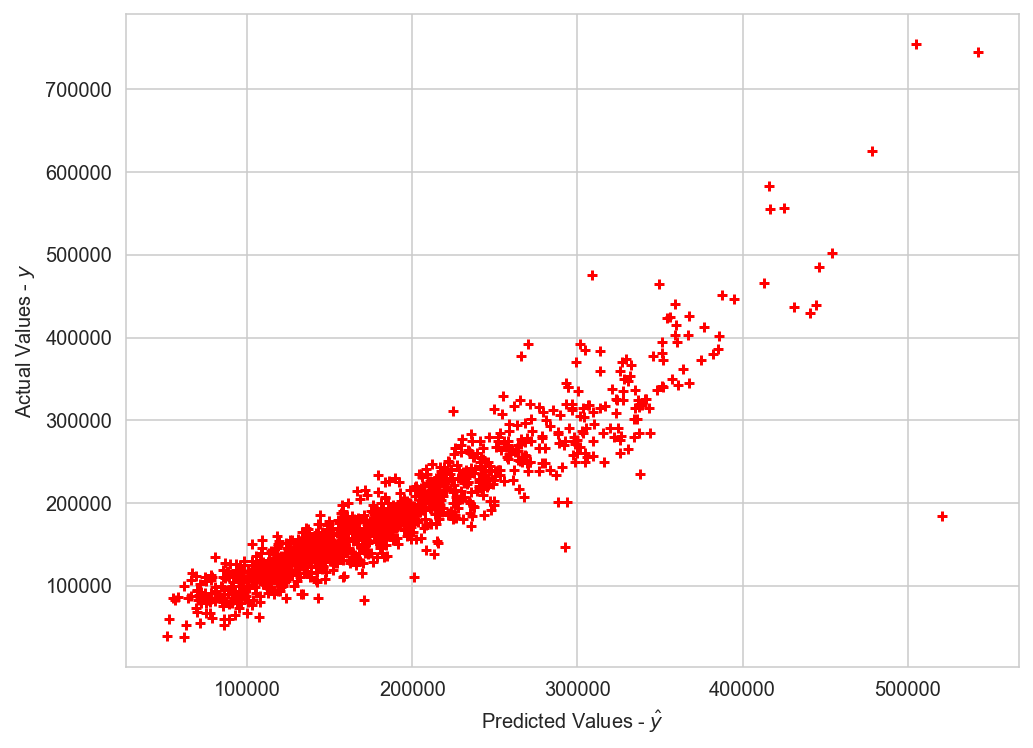

MSE: 830032697.206028


In [97]:
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.api as sm

model = sm.OLS(y_train, X_train)
model = model.fit()
predictions = model.predict(X_train)

# Plot the model
plt.figure(figsize=(8,6))
plt.scatter(predictions, y_train, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
plt.show()

print("MSE:", mean_squared_error(y_train, predictions))

In [98]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     65.59
Date:                Thu, 14 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:10:24   Log-Likelihood:                -14843.
No. Observations:                1270   AIC:                         2.992e+04
Df Residuals:                    1155   BIC:                         3.051e+04
Df Model:                         114                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Id                              -0.5391      2.134     -0.253      0.801      -4.726       3.647
YearBuilt                      360.8618     90.179      4.002      0.000     183.930     537.794
YearRemodAdd                   355.0539     63.446      5.596      0.000     230.572     479.536
BedroomAbvGr                 -9769.4080   1730.641     -5.645      0.000   -1.32e+04   -6373.856
KitchenAbvGr                 -3.457e+04   7420.838     -4.659      0.000   -4.91e+04      -2e+04
TotRmsAbvGrd                  2248.0030   1262.804      1.780      0.075    -229.644    4725.650
Fireplaces                    6789.2340   1774.455      3.826      0.000    3307.718    1.03e+04
GarageYrBlt                    -21.2708     77.924     -0.273      0.785    -174.158     131.617
MoSold                        -381.6844    329.963     -1.157      0.248   -1029.078     265.709
YrSold                         235.0309    813.168      0.289      0.773   -1360.422    1830.483
TotalFullBath                 7648.0796   1662.938      4.599      0.000    4385.361    1.09e+04
MSSubClass                      -0.7194    106.198     -0.007      0.995    -209.082     207.644
LotFrontage                     52.3259     57.655      0.908      0.364     -60.795     165.447
LotArea                          0.7388      0.233      3.165      0.002       0.281       1.197
MasVnrArea                      26.5535      7.519      3.531      0.000      11.800      41.307
TotalBsmtSF                     26.4223      4.349      6.075      0.000      17.889      34.955
GrLivArea                       59.4932      5.115     11.632      0.000      49.458      69.528
GarageArea                      36.0056      7.940      4.535      0.000      20.427      51.584
PoolArea                        92.2549     22.534      4.094      0.000      48.043     136.466
MiscVal                          0.4852      1.908      0.254      0.799      -3.258       4.228
MSZoning_FV                  -2.336e+05    2.2e+05     -1.060      0.289   -6.66e+05    1.99e+05
MSZoning_RH                  -2.372e+05    2.2e+05     -1.080      0.280   -6.68e+05    1.94e+05
MSZoning_RL                  -2.413e+05    2.2e+05     -1.098      0.272   -6.73e+05     1.9e+05
MSZoning_RM                  -2.409e+05    2.2e+05     -1.096      0.273   -6.72e+05     1.9e+05
LotShape_IR1                 -2.432e+05    2.2e+05     -1.106      0.269   -6.75e+05    1.88e+05
LotShape_IR2                 -2.286e+05    2.2e+05     -1.039      0.299    -6.6e+05    2.03e+05
LotShape_IR3                 -2.381e+05    2.2e+05     -1.083      0.279   -6.69e+05    1.93e+05
LotShape_Reg                 -2.431e+05    2.2e+05     -1.105      0.269   -6.75e+05    1.88e+05
LotConfig_Corner             -1.883e+05   1.76e+05     -1.070      0.285   -

In [99]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

from sklearn.metrics import mean_squared_error as ms
train_error = sqrt(ms(y_true=y_train, y_pred=train_predictions))
test_error = sqrt(ms(y_true=y_test, y_pred=test_predictions))
print("RMSE on linear model seen data: {0:.2f}.".format(train_error))
print("RMSE on linear model unseen data: {0:.2f}.".format(test_error))

RMSE on linear model seen data: 28810.29.
RMSE on linear model unseen data: 29626.36.



 
 - The features with a large coefficient and a p value smaller that 0.05 are
 (use html feature for table above)

In [100]:
predictors = ['YearBuilt','YearRemodAdd','BedroomAbvGr','KitchenAbvGr','Fireplaces','TotalFullBath',
              'LotArea','MasVnrArea','TotalBsmtSF','GrLivArea','GarageArea','PoolArea']

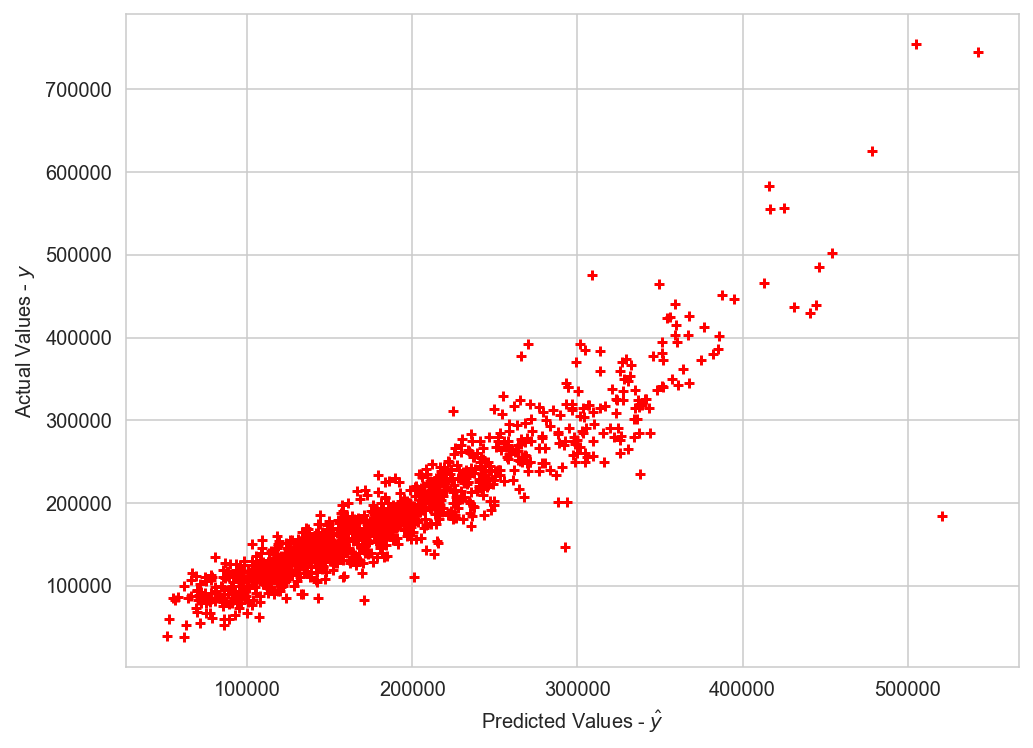

In [101]:
model_1 = sm.OLS(y_train, X_train[predictors])
model_1 = model_1.fit()
predictions = model.predict(X_train)

# Plot the model
plt.figure(figsize=(8,6))
plt.scatter(predictions, y_train, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
plt.show()

In [102]:
train_predictions = model_1.predict(X_train[predictors])
test_predictions = model_1.predict(X_test[predictors])

from sklearn.metrics import mean_squared_error as ms
train_error = sqrt(ms(y_true=y_train, y_pred=train_predictions))
test_error = sqrt(ms(y_true=y_test, y_pred=test_predictions))
print("RMSE on feature selected linear model seen data: {0:.2f}.".format(train_error))
print("RMSW on feature selected linear model unseen data: {0:.2f}.".format(test_error))

RMSE on feature selected linear model seen data: 37197.63.
RMSW on feature selected linear model unseen data: 35964.55.


In [103]:
col_list = list(X_train.columns)

In [104]:
from sklearn.linear_model import LassoCV

las = LassoCV(n_alphas=100, cv=5, fit_intercept=True, normalize=True)
las.fit(X_train, y_train)
coeffs = las.coef_
las_score = las.score(X_test, y_test)
las_alpha = las.alpha_
print (las_score, las_alpha)
# Lasso regression improved the score.

# After lasso regression, 20 out of 25 predictors remain. We will use the first 7 (coefficients are > 7000)
lasso_df = pd.DataFrame([coeffs, col_list], index=['Coeffs', 'Variable']).T
lasso_df = lasso_df[lasso_df.Coeffs !=0]
lasso_df['abs_coeffs'] = lasso_df.Coeffs.map(abs)
lasso_df = lasso_df.sort_values('abs_coeffs', ascending=False)
new_col = lasso_df.Variable.values[0:9]

# The best predictors are:
print ('Best predictors based on lasso are:', new_col)

0.8614400807631452 32.28839469042889
Best predictors based on lasso are: ['Neighborhood_StoneBr' 'Neighborhood_NridgHt' 'Neighborhood_NoRidge'
 'SaleType_Con' 'Neighborhood_Crawfor' 'KitchenAbvGr' 'MasVnrType_BrkCmn'
 'SaleType_New' 'Exterior1st_BrkFace']


In [105]:
lasso_df.tail()

,Coeffs,Variable,abs_coeffs
18,55.3303,PoolArea,55.330335
17,37.3417,GarageArea,37.341723
15,27.7382,TotalBsmtSF,27.738181
14,22.5762,MasVnrArea,22.576177
13,0.645467,LotArea,0.645467


In [106]:
train_predictions = las.predict(X_train)
test_predictions = las.predict(X_test)

from sklearn.metrics import mean_squared_error as ms
train_error = sqrt(ms(y_true=y_train, y_pred=train_predictions))
test_error = sqrt(ms(y_true=y_test, y_pred=test_predictions))
print("RMSE on lasso model seen data: {0:.2f}.".format(train_error))
print("RMSW on lasso model unseen data: {0:.2f}.".format(test_error))

RMSE on lasso model seen data: 30087.06.
RMSW on lasso model unseen data: 29679.63.


In [107]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [108]:
rfr2 = RandomForestRegressor(n_estimators =60,
                            random_state=1111,
                            max_features=20,
                            max_depth=10)
rfr2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features=20, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=60,
                      n_jobs=None, oob_score=False, random_state=1111,
                      verbose=0, warm_start=False)

In [109]:
for i, item in enumerate(rfr2.feature_importances_):
    print("{0:s}: {1:.2f}".format(X_train.columns[i], item))

Id: 0.01
YearBuilt: 0.08
YearRemodAdd: 0.04
BedroomAbvGr: 0.01
KitchenAbvGr: 0.00
TotRmsAbvGrd: 0.03
Fireplaces: 0.04
GarageYrBlt: 0.09
MoSold: 0.01
YrSold: 0.00
TotalFullBath: 0.05
MSSubClass: 0.01
LotFrontage: 0.02
LotArea: 0.04
MasVnrArea: 0.03
TotalBsmtSF: 0.12
GrLivArea: 0.14
GarageArea: 0.10
PoolArea: 0.01
MiscVal: 0.00
MSZoning_FV: 0.00
MSZoning_RH: 0.00
MSZoning_RL: 0.00
MSZoning_RM: 0.00
LotShape_IR1: 0.00
LotShape_IR2: 0.00
LotShape_IR3: 0.00
LotShape_Reg: 0.00
LotConfig_Corner: 0.00
LotConfig_CulDSac: 0.00
LotConfig_FR2: 0.00
LotConfig_FR3: 0.00
LotConfig_Inside: 0.00
Neighborhood_BrkSide: 0.00
Neighborhood_Blueste_NPkVill: 0.00
Neighborhood_Veenker_Timber: 0.00
Neighborhood_BrDale_MeadowV: 0.00
Neighborhood_Blmngtn_ClearCr: 0.00
Neighborhood_SWISU_Sawyer: 0.00
Neighborhood_CollgCr: 0.00
Neighborhood_Crawfor: 0.00
Neighborhood_Edwards: 0.00
Neighborhood_Gilbert: 0.00
Neighborhood_IDOTRR: 0.00
Neighborhood_Mitchel: 0.00
Neighborhood_NAmes: 0.00
Neighborhood_NWAmes: 0.00
Neigh

In [110]:
train_predictions = rfr2.predict(X_train)
test_predictions = rfr2.predict(X_test)

In [111]:
from sklearn.metrics import mean_squared_error as ms
train_error = sqrt(ms(y_true=y_train, y_pred=train_predictions))
test_error = sqrt(ms(y_true=y_test, y_pred=test_predictions))
print("RMSE error for Random Forest on seen data: {0:.2f}.".format(train_error))
print("RMSE error for Random Forest unseen data: {0:.2f}.".format(test_error))

RMSE error for Random Forest on seen data: 15718.84.
RMSE error for Random Forest unseen data: 27622.18.


In [112]:
rf_predictors = ['YearBuilt','YearRemodAdd','BedroomAbvGr','Fireplaces','TotalFullBath','LotFrontage','LotArea','MasVnrArea','TotalBsmtSF',
'GrLivArea','GarageArea','Neighborhood_NoRidge','Neighborhood_NridgHt','RoofStyle_Gable','RoofStyle_Hip','Foundation_PConc',
'GarageType_Attchd']

**RandomForestRegressor appears to be the best model**

In [113]:
rfr3 = RandomForestRegressor(n_estimators =25,
                            random_state=1111,
                            max_features=17) #17 as this is the number of features selected
rfr3.fit(X_train[rf_predictors], y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=17, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=25,
                      n_jobs=None, oob_score=False, random_state=1111,
                      verbose=0, warm_start=False)

In [114]:
train_error = sqrt(ms(y_true=y_train, y_pred=train_predictions))
test_error = sqrt(ms(y_true=y_test, y_pred=test_predictions))
print("RMSE error for Random Forest with features selected on seen data: {0:.2f}.".format(train_error))
print("RMSE error for Random Forest with features selected unseen data: {0:.2f}.".format(test_error))

RMSE error for Random Forest with features selected on seen data: 15718.84.
RMSE error for Random Forest with features selected unseen data: 27622.18.


In [115]:
# r2 = metrics.r2_score(y_train, train_predictions)
# print ("Cross-Predicted R2:", r2)

In [116]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import r2_score
from sklearn import metrics

In [117]:
for folds in range(5,11):
    print('------------------------------------\n')
    print('K:', folds)
    model = rfr2
    
    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=folds)
    print("Cross-validated scores:", scores)
    print("Mean CV R2:", np.mean(scores))
    print('Std CV R2:', np.std(scores))
    
    # Make cross-validated predictions
    predictions = cross_val_predict(model, X_train, y_train, cv=folds)
    
    r2 = metrics.r2_score(y_train, predictions)
    print("Cross-Predicted R2:", r2)

------------------------------------

K: 5
Cross-validated scores: [0.85623735 0.7960362  0.82647206 0.87165009 0.81341395]
Mean CV R2: 0.8327619308135892
Std CV R2: 0.027662502341476256
Cross-Predicted R2: 0.829109687842051
------------------------------------

K: 6
Cross-validated scores: [0.84333171 0.85652198 0.76666721 0.88158483 0.82449942 0.8420199 ]
Mean CV R2: 0.8357708397593745
Std CV R2: 0.03542152127009257
Cross-Predicted R2: 0.829701176279607
------------------------------------

K: 7
Cross-validated scores: [0.82384918 0.88129899 0.78213746 0.82850683 0.87892037 0.7784712
 0.84033222]
Mean CV R2: 0.830502320019144
Std CV R2: 0.038014808454280694
Cross-Predicted R2: 0.8254656461679819
------------------------------------

K: 8
Cross-validated scores: [0.83157361 0.87253069 0.77043095 0.79725203 0.88559508 0.88702706
 0.79950609 0.84127819]
Mean CV R2: 0.8356492110717406
Std CV R2: 0.041196031253953415
Cross-Predicted R2: 0.8286006999818569
---------------------------------



##  Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [118]:
house_non_fixed.head()

,SalePrice,YrSold,OverallQual,OverallCond,ExterQual,BsmtCond,BsmtFinType1,HeatingQC,KitchenQual,GarageFinish,GarageQual,LowQualFinSF,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl
0,208500,2008,7,5,2,3,7,4,3,3,3,0,1,0,0,0,0,0,0
1,181500,2007,6,8,1,3,6,4,2,3,3,0,1,0,0,0,0,0,0
2,223500,2008,7,5,2,3,7,4,3,3,3,0,1,0,0,0,0,0,0
3,140000,2006,7,5,1,4,6,3,3,2,3,0,1,0,0,0,0,0,0
4,250000,2008,8,5,2,3,7,4,3,3,3,0,1,0,0,0,0,0,0


In [119]:
#test
house_non_fixed_2010_w_target = house_non_fixed[house_non_fixed.YrSold == 2010]
# target_nf_2010 = house_non_fixed_2010_w_target['SalePrice']
house_non_fixed_2010 = house_non_fixed_2010_w_target.drop(['SalePrice','YrSold'],axis=1)

#train
house_nf_w_target_pre2010 = house_non_fixed[house_fixed.YrSold < 2010]
# target_nf_pre_2010 = house_nf_w_target_pre2010['SalePrice']
house_nf_pre_2010 = house_nf_w_target_pre2010.drop(['SalePrice','YrSold'], axis=1)

# predictions = rfr2.predict(X_test)


X_train_nf = house_nf_pre_2010
y_train_nf = y_train - rfr2.predict(X_train)
y_train_nf = pd.DataFrame(y_train_nf)
# y_train_reno = y_train - lasso.predict(X_train_ss)

X_test_nf = house_non_fixed_2010
y_test_nf = y_test - rfr2.predict(X_test)
# y_test_reno = y_test - predictions

In [120]:
predictions.shape

(1270,)

In [121]:
print(X_train_nf.shape)
print(y_train_nf.shape)
print(X_test_nf.shape)
print(y_test_nf.shape)

(1270, 17)
(1270, 1)
(172, 17)
(172,)


In [122]:
X_train_nf.describe()

,OverallQual,OverallCond,ExterQual,BsmtCond,BsmtFinType1,HeatingQC,KitchenQual,GarageFinish,GarageQual,LowQualFinSF,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl
count,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000
mean,6.119685,5.576378,1.401575,2.938583,4.188189,3.165354,2.514173,2.664567,2.813386,6.007874,0.981890,0.000787,0.000787,0.000787,0.008661,0.002362,0.004724
std,1.373453,1.103077,0.566463,0.556649,2.523338,0.950830,0.663850,1.014126,0.717216,48.929727,0.133403,0.028061,0.028061,0.028061,0.092699,0.048564,0.068599
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,5.000000,1.000000,3.000000,1.000000,2.000000,2.000000,2.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,5.000000,1.000000,3.000000,5.000000,4.000000,2.000000,3.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.000000,6.000000,2.000000,3.000000,7.000000,4.000000,3.000000,3.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10.000000,9.000000,3.000000,4.000000,7.000000,4.000000,4.000000,4.000000,5.000000,572.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [123]:
X_train_nf.isnull().sum().any()

False

In [124]:
y_train_nf.isnull().sum()

SalePrice    0
dtype: int64

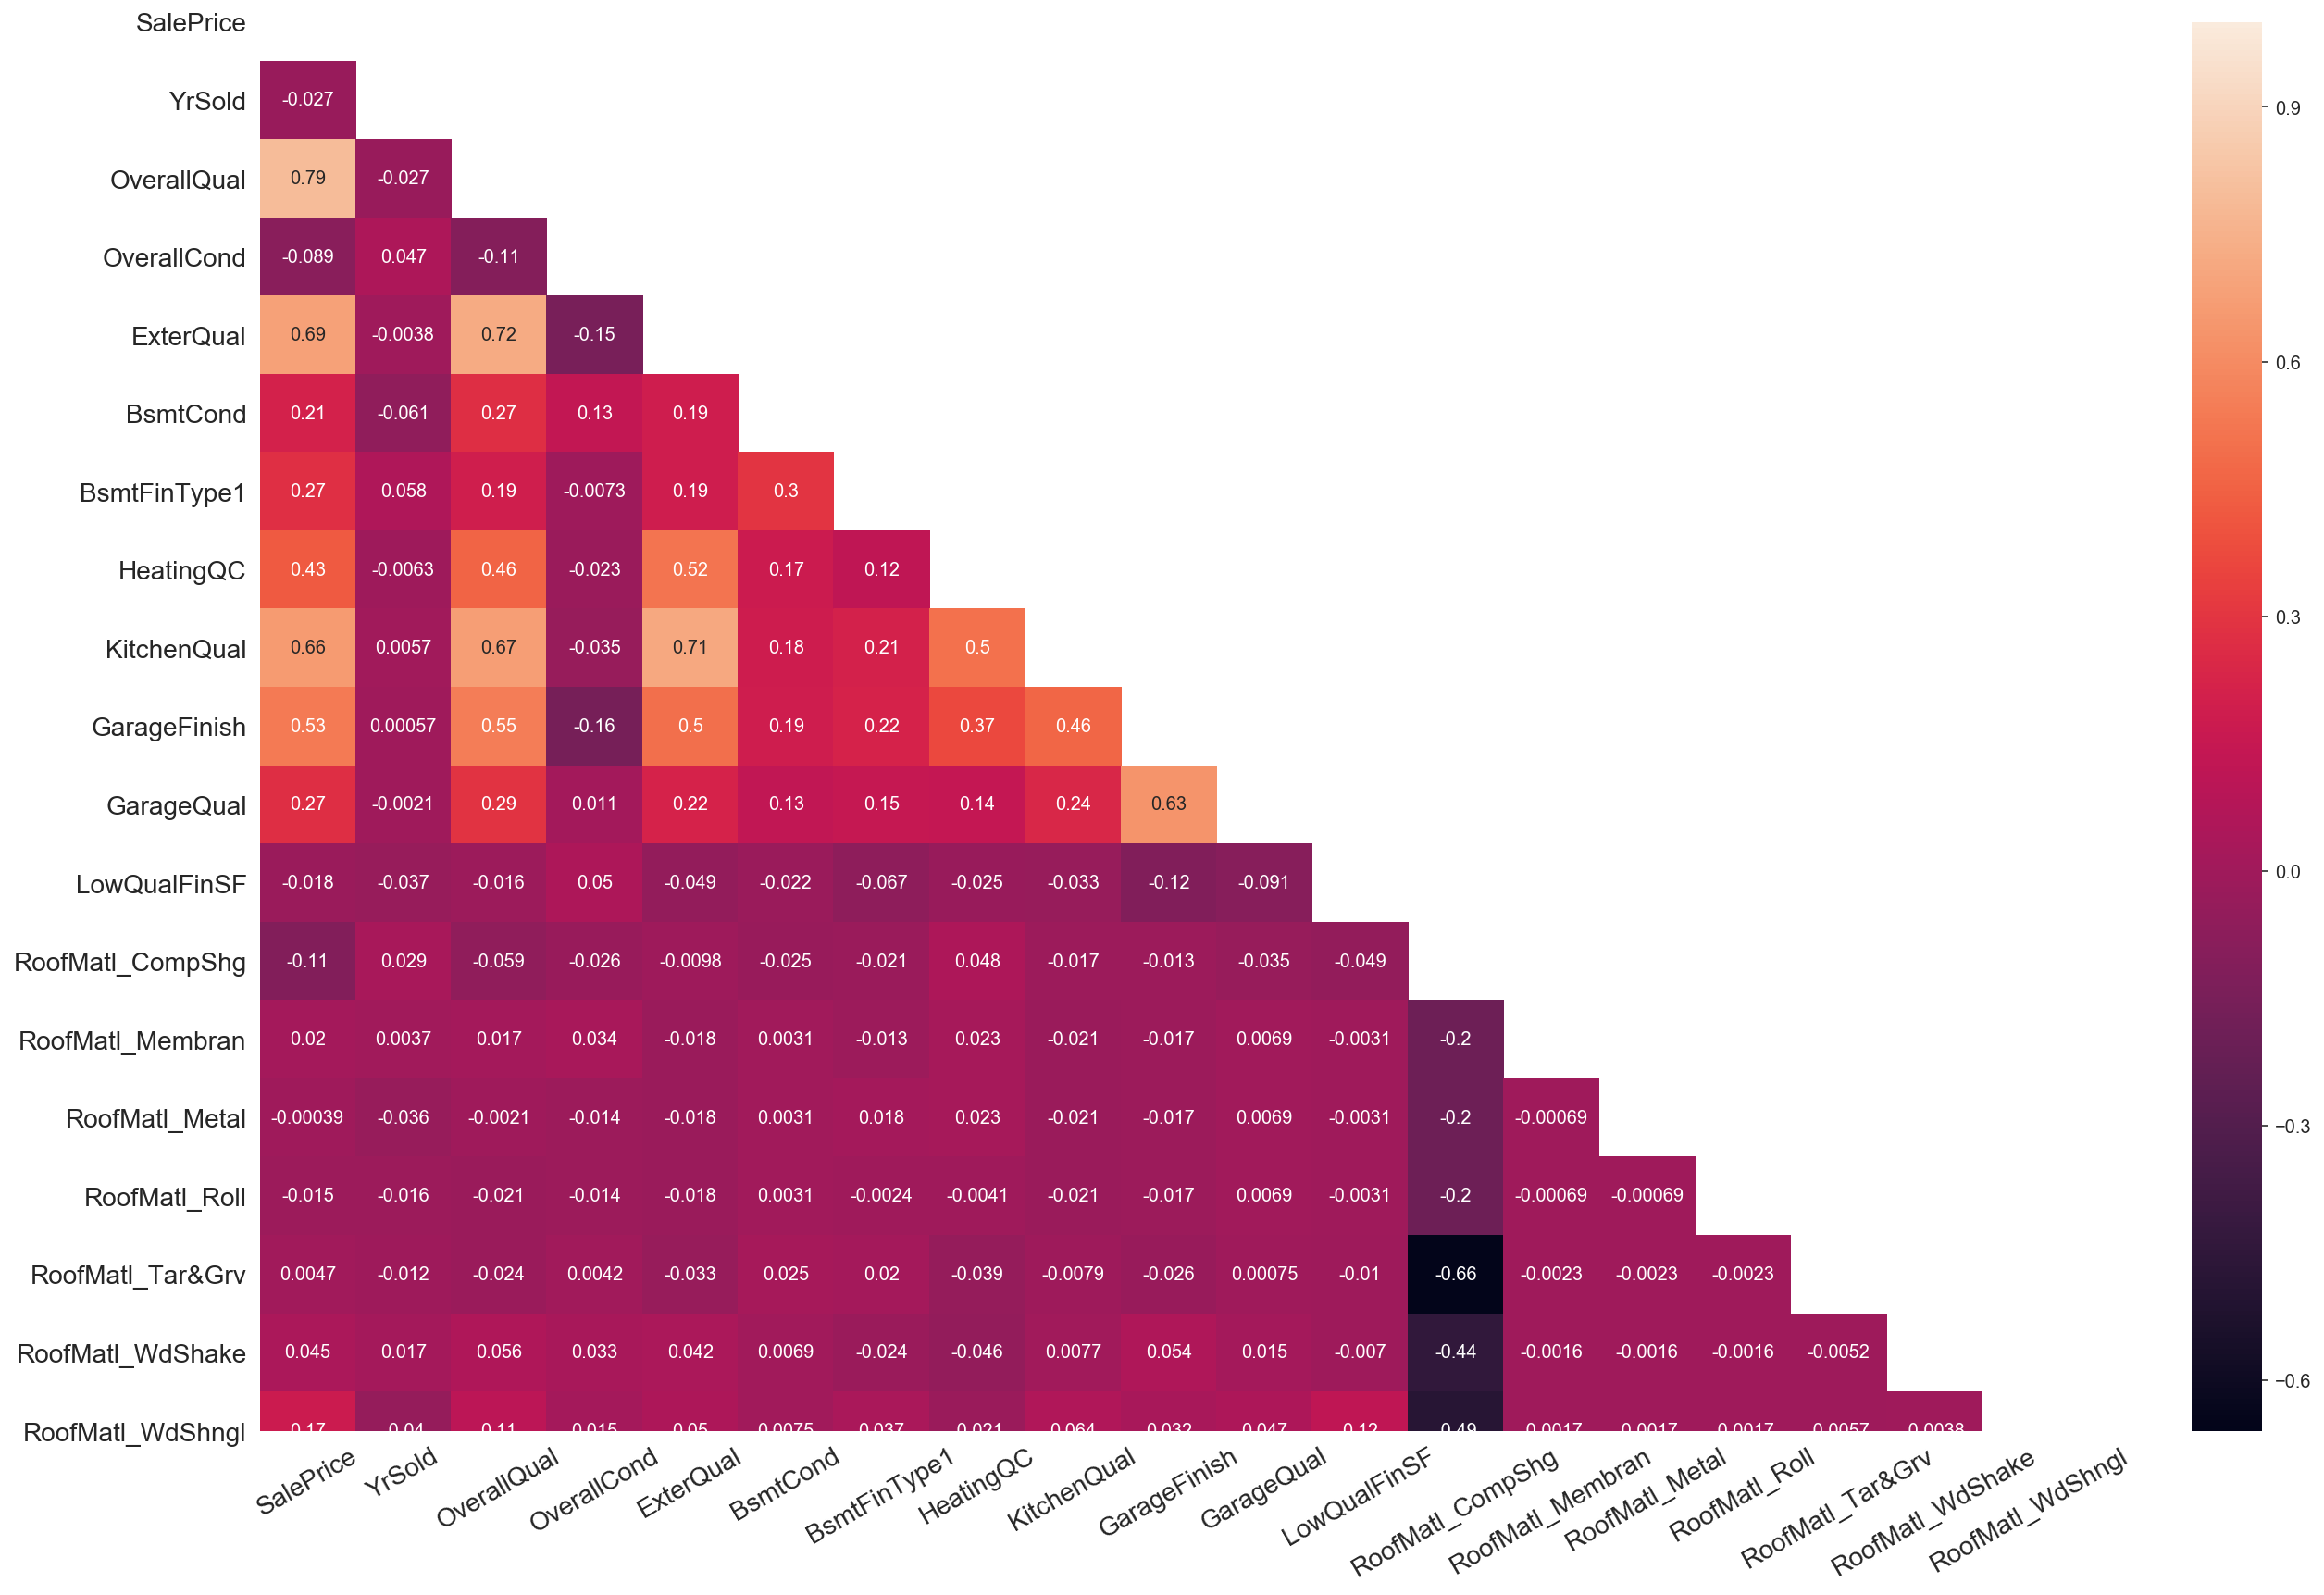

In [125]:
def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(22,14))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

correlation_heat_map(house_non_fixed)

**I will use lasso as it will give a linear model and it will be easy to predict increase in house price using coefficient**

In [126]:
col_list = list(X_train_nf.columns)

In [127]:
las = LassoCV(n_alphas=100, cv=5, fit_intercept=True, normalize=True)
las.fit(X_train_nf, y_train_nf)
coeffs = las.coef_
las_score = las.score(X_test_nf, y_test_nf)
las_alpha = las.alpha_
print (las_score, las_alpha)
# Lasso regression improved the score.

# After lasso regression, 20 out of 25 predictors remain. We will use the first 7 (coefficients are > 7000)
lasso_df = pd.DataFrame([coeffs, col_list], index=['Coeffs', 'Variable']).T
lasso_df = lasso_df[lasso_df.Coeffs !=0]
lasso_df['abs_coeffs'] = lasso_df.Coeffs.map(abs)
lasso_df = lasso_df.sort_values('abs_coeffs', ascending=False)
new_col = lasso_df.Variable.values[0:9]

# The best predictors are:
print ('Best predictors based on lasso are:', new_col)

0.15086726610980206 8.032547251380153
Best predictors based on lasso are: ['RoofMatl_WdShngl' 'RoofMatl_Membran' 'OverallCond' 'OverallQual'
 'RoofMatl_CompShg' 'BsmtFinType1' 'KitchenQual' 'LowQualFinSF']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [128]:
lasso_df.head(10)

,Coeffs,Variable,abs_coeffs
16,35564.1,RoofMatl_WdShngl,35564.145363
11,16399,RoofMatl_Membran,16399.046973
1,3679.24,OverallCond,3679.244794
0,3196.34,OverallQual,3196.337068
10,-2183.98,RoofMatl_CompShg,2183.978931
4,893.475,BsmtFinType1,893.474702
6,817.004,KitchenQual,817.003719
9,-13.2213,LowQualFinSF,13.221257


- The Lasso model is a linear regression model so we are able to intepret the increase or decrease in price based on the coeeffient of that non-fixed feature.
- Accordining to this lasso model the top non fixed features which can improve sale price are:
    - RoofMatl_WdShngl - The roof material being Wood Shingles - an increase in price of \$35,972
    - RoofMatl_Membran - The roof material being Membrane - increase in price of 19,063
    - OverallCond - The overall condition of the house from every increase in rating from 1 (Very Poor) to 10 (Very Excellent), an increase in price of 3,726
    - OverallQual - The overall material and finish of the house from every increase in rating from 1 (Very Poor) to 10 (Very Excellent), an increase in price of 2,730
    
    
    
    
    

In [129]:
len(train_predictions)

1270

In [130]:
len(y_test_nf)

172

In [131]:
train_predictions = las.predict(X_train_nf)
test_predictions = las.predict(X_test_nf)

from sklearn.metrics import mean_squared_error as ms
train_error = sqrt(ms(y_true=y_train_nf, y_pred=train_predictions))
test_error = sqrt(ms(y_true=y_test_nf, y_pred=test_predictions))
print("RMSE on linear model seen data: {0:.2f}.".format(train_error))
print("RMSE on linear model unseen data: {0:.2f}.".format(test_error))

RMSE on linear model seen data: 13530.00.
RMSE on linear model unseen data: 25415.31.


In [132]:
r2 = metrics.r2_score(y_train_nf, train_predictions)
print ("Cross-Predicted R2:", r2)

Cross-Predicted R2: 0.2591088643632917


## What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

- The data set house is the edition which was before the get dummies step. The SaleCondition column was split in get dummies so that is why the house dataset is required
- As the only option of interest is if the sale was abnormal or not, using a dictionary the Sale Condition column will be labeled 0 or 1. With 1 being if the Sale was abnormal or not

In [133]:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,Condition1,BldgType,...,GarageArea,GarageQual,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalFullBath
0,1,60,RL,65.0,8450,Reg,Inside,CollgCr,Norm,1Fam,...,548,3,0,0,2,2008,WD,Normal,208500,3
1,2,20,RL,80.0,9600,Reg,FR2,Veenker,Feedr,1Fam,...,460,3,0,0,5,2007,WD,Normal,181500,2
2,3,60,RL,68.0,11250,IR1,Inside,CollgCr,Norm,1Fam,...,608,3,0,0,9,2008,WD,Normal,223500,3
3,4,70,RL,60.0,9550,IR1,Corner,Crawfor,Norm,1Fam,...,642,3,0,0,2,2006,WD,Abnorml,140000,2
4,5,60,RL,84.0,14260,IR1,FR2,NoRidge,Norm,1Fam,...,836,3,0,0,12,2008,WD,Normal,250000,3


In [134]:
house.SaleCondition.value_counts()

Normal     1189
Partial     122
Abnorml      96
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [135]:
house_3 = house.copy()

In [136]:
SaleCondition_map = { 'Normal': 0,
                     'Partial': 0,
                     'Abnorml': 1,
                     'Family': 0,
                     'Alloca': 0, 
                   'AdjLand': 0
                 }
house_3['SaleCondition'] = house_3.SaleCondition.map(SaleCondition_map)

In [137]:
house_3 = pd.get_dummies(house_3, columns=['MSZoning', 'LotShape', 'LotConfig', 'Neighborhood', 'Condition1',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'MasVnrType', 'Foundation', 'GarageType', 'SaleType'], prefix = ['MSZoning', 'LotShape', 'LotConfig', 'Neighborhood', 'Condition1',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'MasVnrType', 'Foundation', 'GarageType', 'SaleType'])

In [138]:
y = house_3.SaleCondition
X = house_3.drop(['SaleCondition','Id'], axis=1)


**Split the data into training, validation, and testing datasets**

In [139]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.4, random_state=1111)



- This is a Classification problem - The response is categorical - is the Sale condition abnormal or not? 
- Random Forest is good for looking at multiple features which independently have little impact on the target but working as a group have a large impact on the target
- Random forest Classifier also has a bootstrap function which will be useful for this data set with such a large imbalance (default parameter is bootstrap=True)
- As the sample is small the test size has been adjusted to 0.4
- It was also necessary to adjust the hyperparameter n_estimators to a low value of 15 so that there were positive values in the test data set

In [140]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

Fit the model

In [141]:
rfc= RandomForestClassifier(random_state=1111,n_estimators=20, max_depth=10)
rfc.fit(X_train ,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=1111,
                       verbose=0, warm_start=False)

In [142]:
train_predictions_rfc = rfc.predict(X_train)
test_predictions_rfc = rfc.predict(X_test)



View Confusion Matrix for training data
- This matrix is perfect for binary outcomes (such as abnormal or not). It shows the Predicted Values vs Actual Values
- The row index represents the 'True' category and the column index represents the 'Predicted' category
- The format is:
    -  TN   |     FP
    -  FN   |     TP

In [143]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, train_predictions_rfc)
print(cm)

[[811   1]
 [ 20  33]]


In [144]:
from sklearn.metrics import classification_report, roc_auc_score
print("=== Classification Report ===")
print(classification_report(y_train, train_predictions_rfc))
print("=== ROC AUC Score ===")
print(roc_auc_score(y_train, train_predictions_rfc))

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       812
           1       0.97      0.62      0.76        53

    accuracy                           0.98       865
   macro avg       0.97      0.81      0.87       865
weighted avg       0.98      0.98      0.97       865

=== ROC AUC Score ===
0.8107049911701831




- **Precision** represents the number of True positives out of all predicted positive values. This is used when it is undesirable to over predict positive values. It is calculated as TP / (TP + FP) 
- **Recall** is about finding all positive values. It is used when it cannot be afforded to miss any positive values
- **ROC AUC** finds the optimal balance between sensitivity (precision/ ration of positive values) and specificity (ratio of negative values) The AUC (area under curve) lies between 0.5 to 1 where 0.5 denotes a bad classifer and 1 denotes an excellent classifier

- The train data got high precision and recall scores, both are 0.97
- The AUC is a fairly good value at 0.77

**View Confusion Matrix for test data** 

In [145]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, test_predictions_rfc)
print(cm)

[[528   6]
 [ 39   4]]


In [146]:
from sklearn.metrics import classification_report, roc_auc_score
print("=== Classification Report ===")
print(classification_report(y_test, test_predictions_rfc))
print("=== ROC AUC Score ===")
print(roc_auc_score(y_test, test_predictions_rfc))

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       534
           1       0.40      0.09      0.15        43

    accuracy                           0.92       577
   macro avg       0.67      0.54      0.56       577
weighted avg       0.89      0.92      0.90       577

=== ROC AUC Score ===
0.5408936503788868



- The train data got high precision and recall scores, 0.89 and 0.92 respectively
- The AUC is very low at 0.54 but this is because of the small sample size for the test set and the extreme imbalance
- Therefore the precision and recall scores are better metrics to measure test data result


    
**Check for feature importance**    

- Using the for loop below the features are listed which have an effect on the outcome of the sale condition being Abnormal or not. 
- For Random Forest Feature importance is calculated as the decrease in node impurity weighted by the probability of reaching that node
- The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value the more important the feature.
- The top features are (in descending order):
     - GrLivArea 0.05
     - GarageYrBlt 0.05
     - SalePrice 0.05
     - SaleType_WD 0.05
     - GarageArea 0.04
     - MoSold 0.04
     - LotArea 0.03
     - YearRemodAdd 0.03


In [147]:
for i, item in enumerate(rfc.feature_importances_):
    print("{0:s}: {1:.2f}".format(X_train.columns[i], item))

MSSubClass: 0.01
LotFrontage: 0.02
LotArea: 0.03
OverallQual: 0.01
OverallCond: 0.01
YearBuilt: 0.02
YearRemodAdd: 0.03
MasVnrArea: 0.01
ExterQual: 0.01
BsmtCond: 0.01
BsmtFinType1: 0.02
TotalBsmtSF: 0.03
HeatingQC: 0.02
LowQualFinSF: 0.00
GrLivArea: 0.05
BedroomAbvGr: 0.02
KitchenAbvGr: 0.00
KitchenQual: 0.02
TotRmsAbvGrd: 0.02
Fireplaces: 0.01
GarageYrBlt: 0.05
GarageFinish: 0.01
GarageArea: 0.04
GarageQual: 0.01
PoolArea: 0.01
MiscVal: 0.00
MoSold: 0.04
YrSold: 0.01
SalePrice: 0.05
TotalFullBath: 0.02
MSZoning_FV: 0.01
MSZoning_RH: 0.00
MSZoning_RL: 0.00
MSZoning_RM: 0.00
LotShape_IR1: 0.01
LotShape_IR2: 0.00
LotShape_IR3: 0.00
LotShape_Reg: 0.01
LotConfig_Corner: 0.01
LotConfig_CulDSac: 0.00
LotConfig_FR2: 0.00
LotConfig_FR3: 0.00
LotConfig_Inside: 0.01
Neighborhood_Blmngtn: 0.00
Neighborhood_Blueste: 0.00
Neighborhood_BrDale: 0.00
Neighborhood_BrkSide: 0.00
Neighborhood_ClearCr: 0.00
Neighborhood_CollgCr: 0.00
Neighborhood_Crawfor: 0.00
Neighborhood_Edwards: 0.01
Neighborhood_Gilb



**Cross Validation**

- The cross validation checks the predictions running multiple times
- The precision, recall and AUC are high which validates this model

In [148]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring= 'roc_auc')

In [149]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, test_predictions_rfc))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, test_predictions_rfc))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[528   6]
 [ 39   4]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       534
           1       0.40      0.09      0.15        43

    accuracy                           0.92       577
   macro avg       0.67      0.54      0.56       577
weighted avg       0.89      0.92      0.90       577



=== All AUC Scores ===
[0.63259259 0.65333333 0.83851852 0.67777778 0.7162963  0.69481481
 0.74709784 0.82172471 0.84660033 0.62313433]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.7251890547263681
